# Analytics

#### Date: 2020/05

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Arthur Matos
- Brian Pina
- Gabriel Sabanai
- Guilherme Marques
- Luiz Henrique Zamprogno
- Luiz Pettengill
- Matheus Blanco
- Pedro Féo
- Saleh Kader
- Victor Buendia


### LIBRARIES

In [18]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [19]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [20]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [21]:
repos = [
    'Eccoar_Complaint',
    'eccoar_frontend',
    'Eccoar_Gateway',
    'Eccoar_Mailer',
    'Eccoar_Reports',
    'Eccoar_Users'
]

language = [['Eccoar_Complaint', 'ts'], 
            ['eccoar_frontend', 'ts'], 
            ['Eccoar_Gateway', 'ts'], 
            ['Eccoar_Mailer', 'ts'], 
            ['Eccoar_Reports', 'ts'], 
            ['Eccoar_Users', 'ts']]

repos_lenguage = {}

for item in language:
    repos_lenguage[f"{item[0]}"] = item[1]

In [22]:
repos_lenguage

{'Eccoar_Complaint': 'ts',
 'eccoar_frontend': 'ts',
 'Eccoar_Gateway': 'ts',
 'Eccoar_Mailer': 'ts',
 'Eccoar_Reports': 'ts',
 'Eccoar_Users': 'ts'}

##### Path to the folder with all your jsons

In [23]:
jsons = glob('**/*.json') # add the path here

In [24]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df, repos

#### Create base component dataframe

In [25]:
base_component_df, repos = create_base_component_df(jsons)

In [26]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
96,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
97,functions,42,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
98,test_execution_time,70,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
99,security_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
100,tests,21,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
101,files,19,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
102,complexity,60,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
103,ncloc,626,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
104,coverage,68.2,False,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
105,reliability_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00


#### Create dataframe per file

In [27]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [28]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [29]:
file_component_df = create_file_df(jsons)

In [30]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
88,src/migration/1618526567509-CreateComplaint.ts,2,2,0.0,0.0,0.0,76,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
89,src/migration/1618529825437-CreateVote.ts,2,2,0.0,0.0,0.0,38,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
90,src/utils/Category.ts,0,0,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
91,src/entity/Complaint.ts,0,0,0.0,0.0,100.0,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
92,src/repositories/ComplaintRepository.ts,7,7,0.0,0.0,61.3,80,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
93,src/utils/ComplaintUpvote.ts,1,3,0.0,0.0,63.6,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
94,src/utils/ComplaintVote.ts,0,0,0.0,0.0,NaN,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
95,src/utils/ComplaintVoteConfirmed.ts,1,3,0.0,0.0,92.3,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
96,src/utils/ComplaintWithVote.ts,0,0,0.0,0.0,NaN,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00
97,src/controllers/ControllerComplaint.ts,13,24,0.0,0.0,90.3,170,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021-00:00


In [31]:
file_component_df['version'] = pd.to_datetime(file_component_df['version'], format='%d-%m-%Y-%H:%M')

In [32]:
file_component_df = file_component_df.sort_values(by='version')
file_component_df.head()

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
635,src/controllers/ControllerReport.ts,1,1,0.0,0.0,100.0,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Reports-23-03-2021-0...,Eccoar_Reports,2021-03-23
12,src/repositories/LocalizationRepository.ts,1,1,0.0,0.0,0.0,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Users-23-03-2021-00:...,Eccoar_Users,2021-03-23
13,src/routes.ts,2,2,0.0,0.0,0.0,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Users-23-03-2021-00:...,Eccoar_Users,2021-03-23
14,src/server.ts,1,2,0.0,0.0,0.0,14,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Users-23-03-2021-00:...,Eccoar_Users,2021-03-23
549,src/server.ts,1,2,0.0,0.0,0.0,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Mailer-23-03-2021-00...,Eccoar_Mailer,2021-03-23


In [33]:
file_component_df.to_excel('data.xlsx', index = False)

In [34]:
file_component_df.repository.unique()

array(['Eccoar_Reports', 'Eccoar_Users', 'Eccoar_Mailer',
       'eccoar_frontend', 'Eccoar_Gateway', 'Eccoar_Complaint'],
      dtype=object)

#### Create dataframe per repository

In [35]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['Eccoar_Complaint', 'eccoar_frontend', 'Eccoar_Gateway', 'Eccoar_Mailer', 'Eccoar_Reports', 'Eccoar_Users'])

In [36]:
repository_dataframes["Eccoar_Complaint"].head()

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
223,src/entity/Votes.ts,0,0,0.0,0.0,NaN,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021...,Eccoar_Complaint,2021-03-23
224,src/repositories/VotesRepository.ts,1,1,0.0,0.0,0.0,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021...,Eccoar_Complaint,2021-03-23
216,src/utils/Category.ts,0,0,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021...,Eccoar_Complaint,2021-03-23
217,src/entity/Complaint.ts,0,0,0.0,0.0,100.0,28,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021...,Eccoar_Complaint,2021-03-23
218,src/repositories/ComplaintRepository.ts,3,3,0.0,0.0,46.7,27,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021...,Eccoar_Complaint,2021-03-23


### Metric calculations

##### COMPLEXITY

In [37]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [38]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [39]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

### Calculate m1, m2 and m3 for each repository

In [40]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list})
        
    return metrics_df

In [41]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df

### Data visualization

- You must do this for each of your repositories

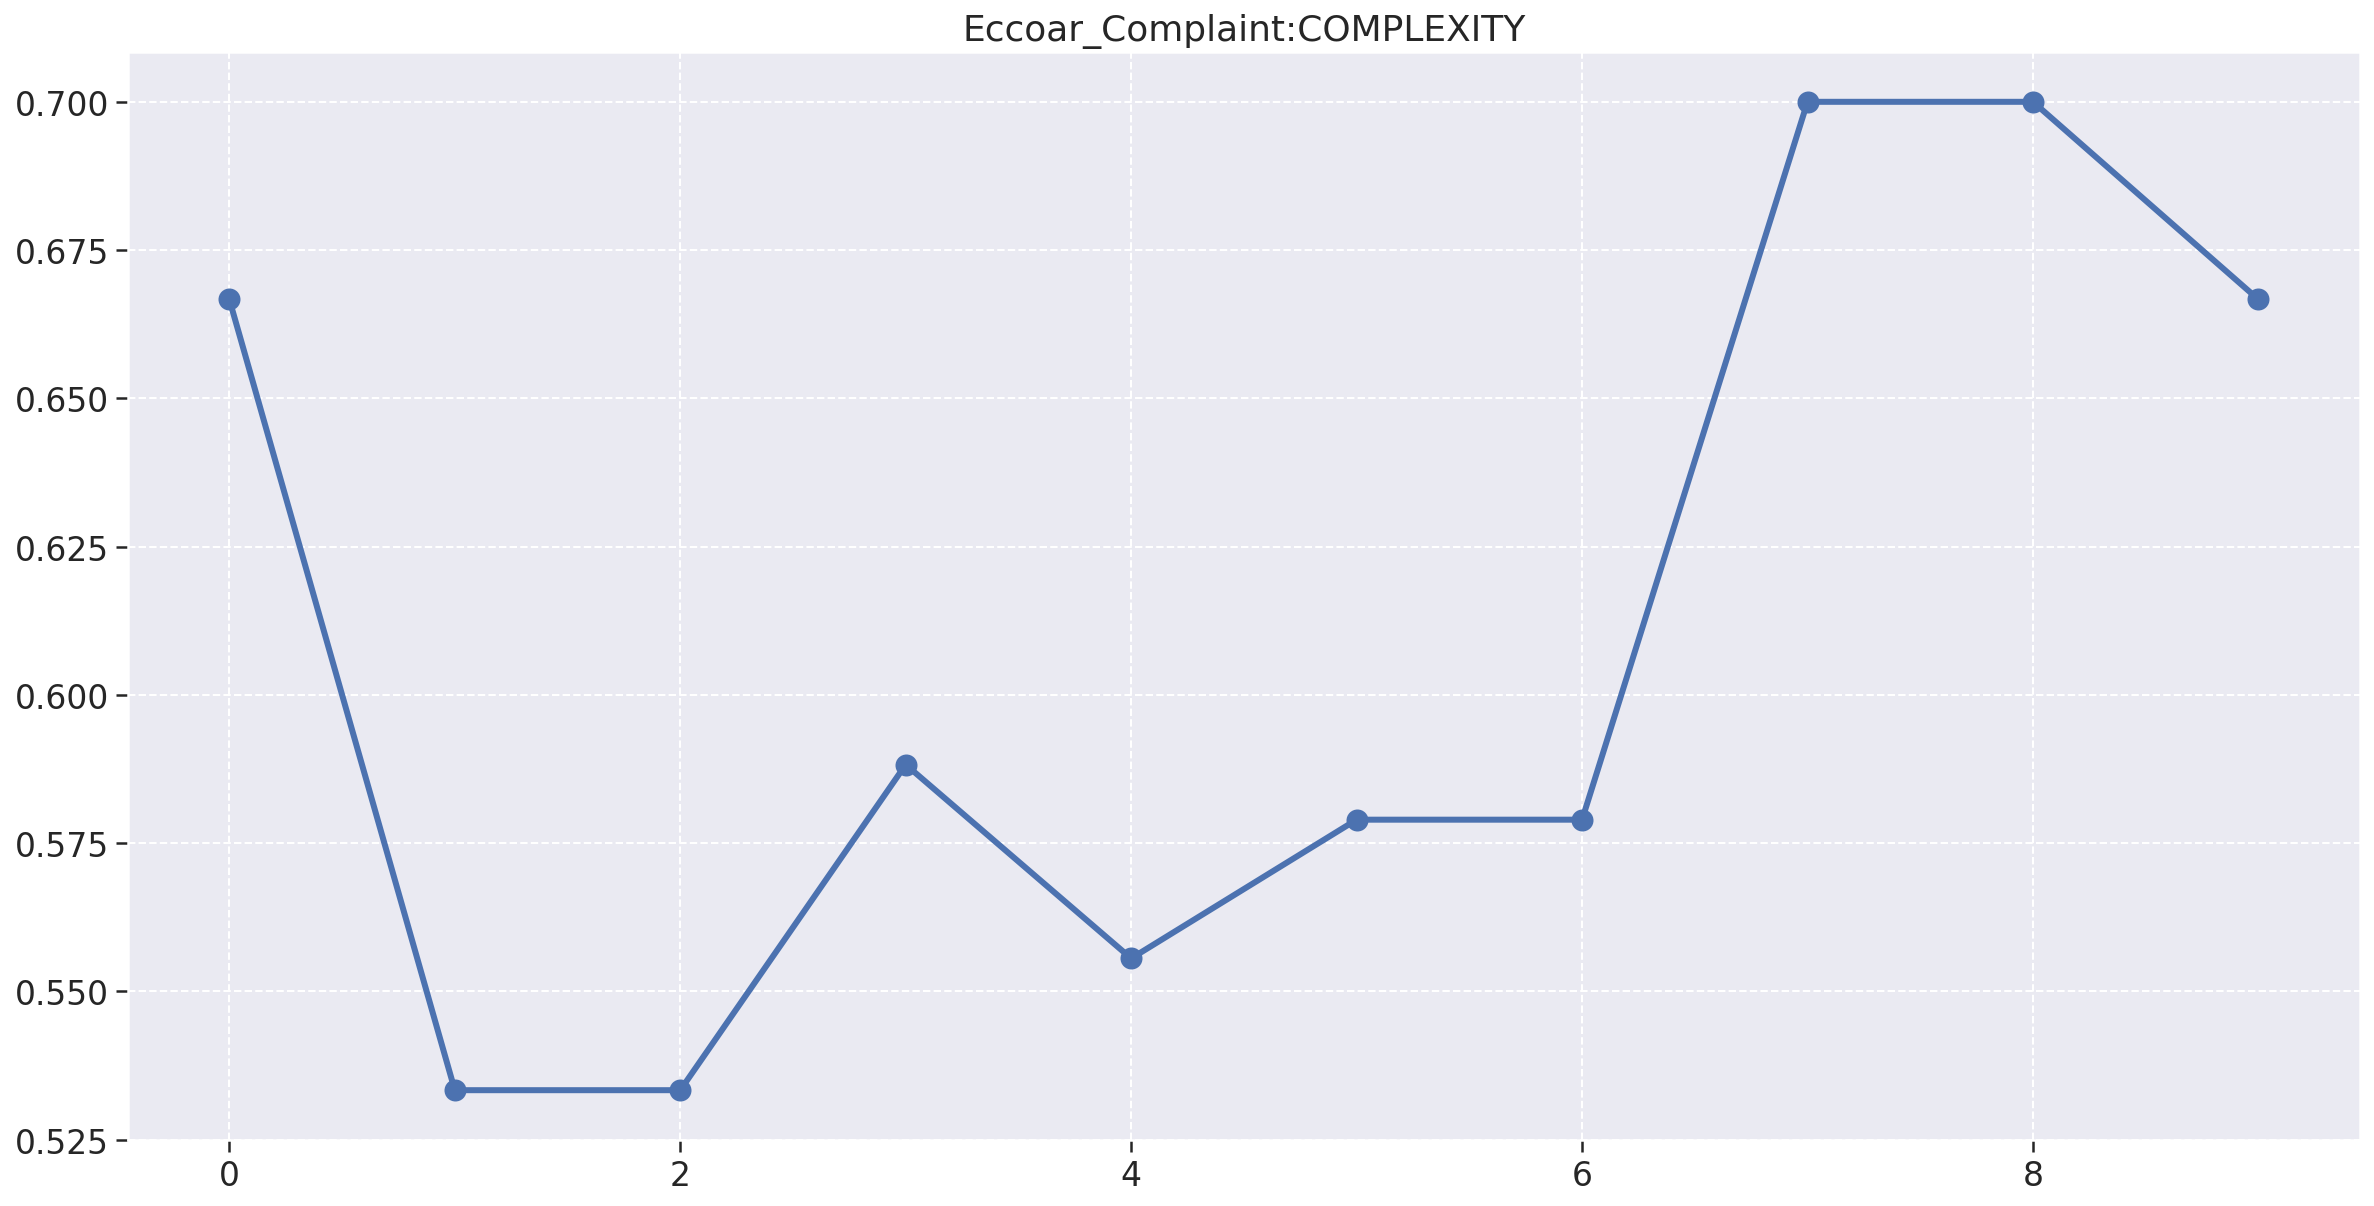

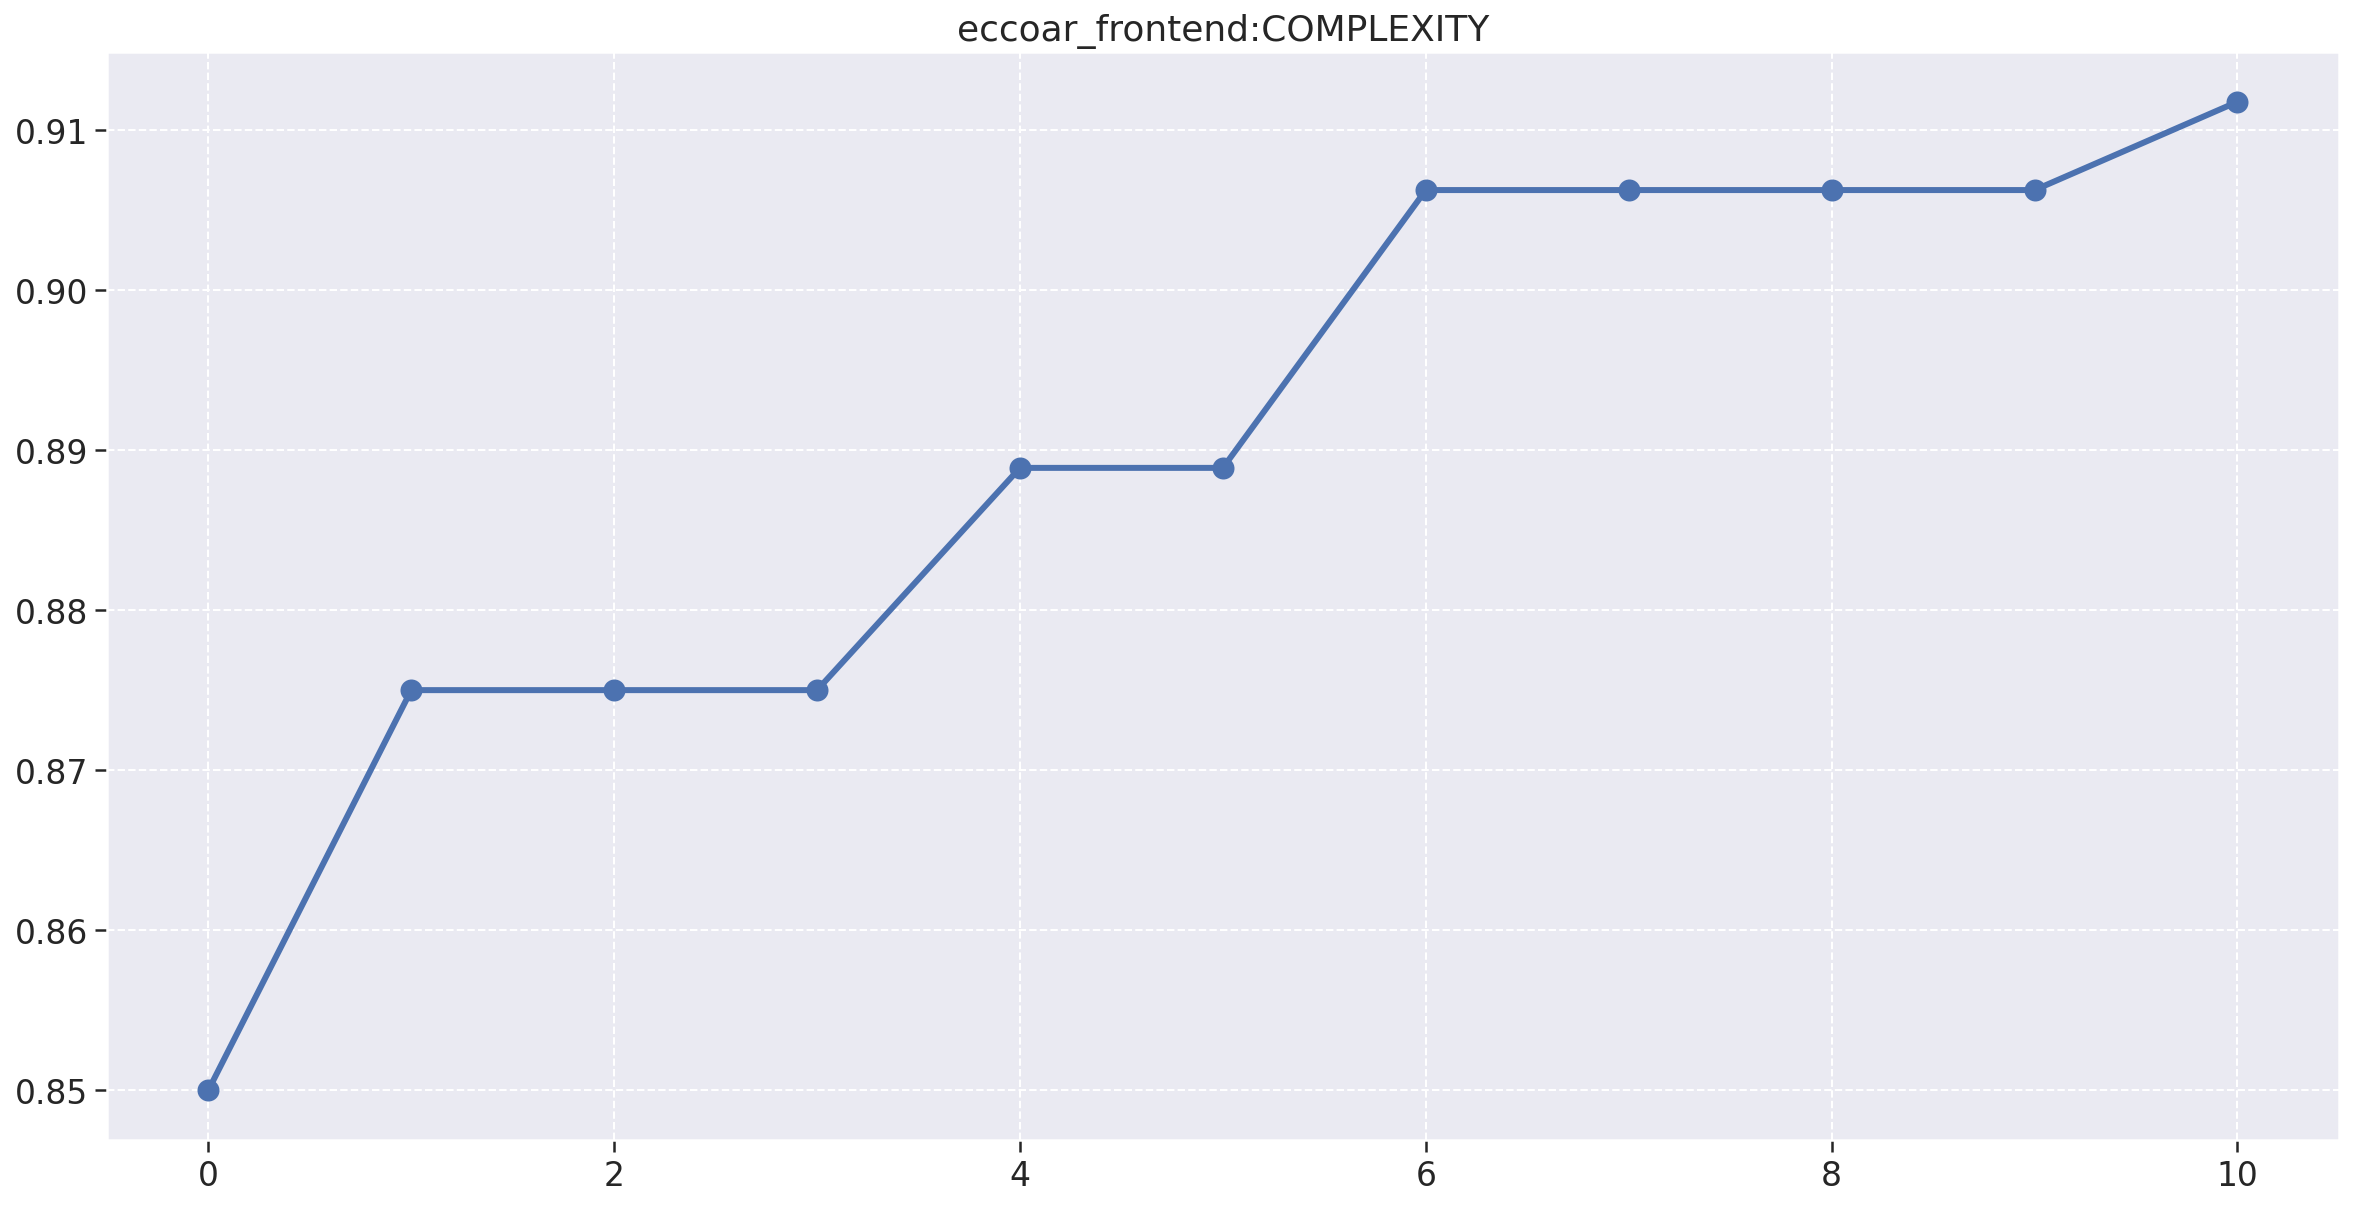

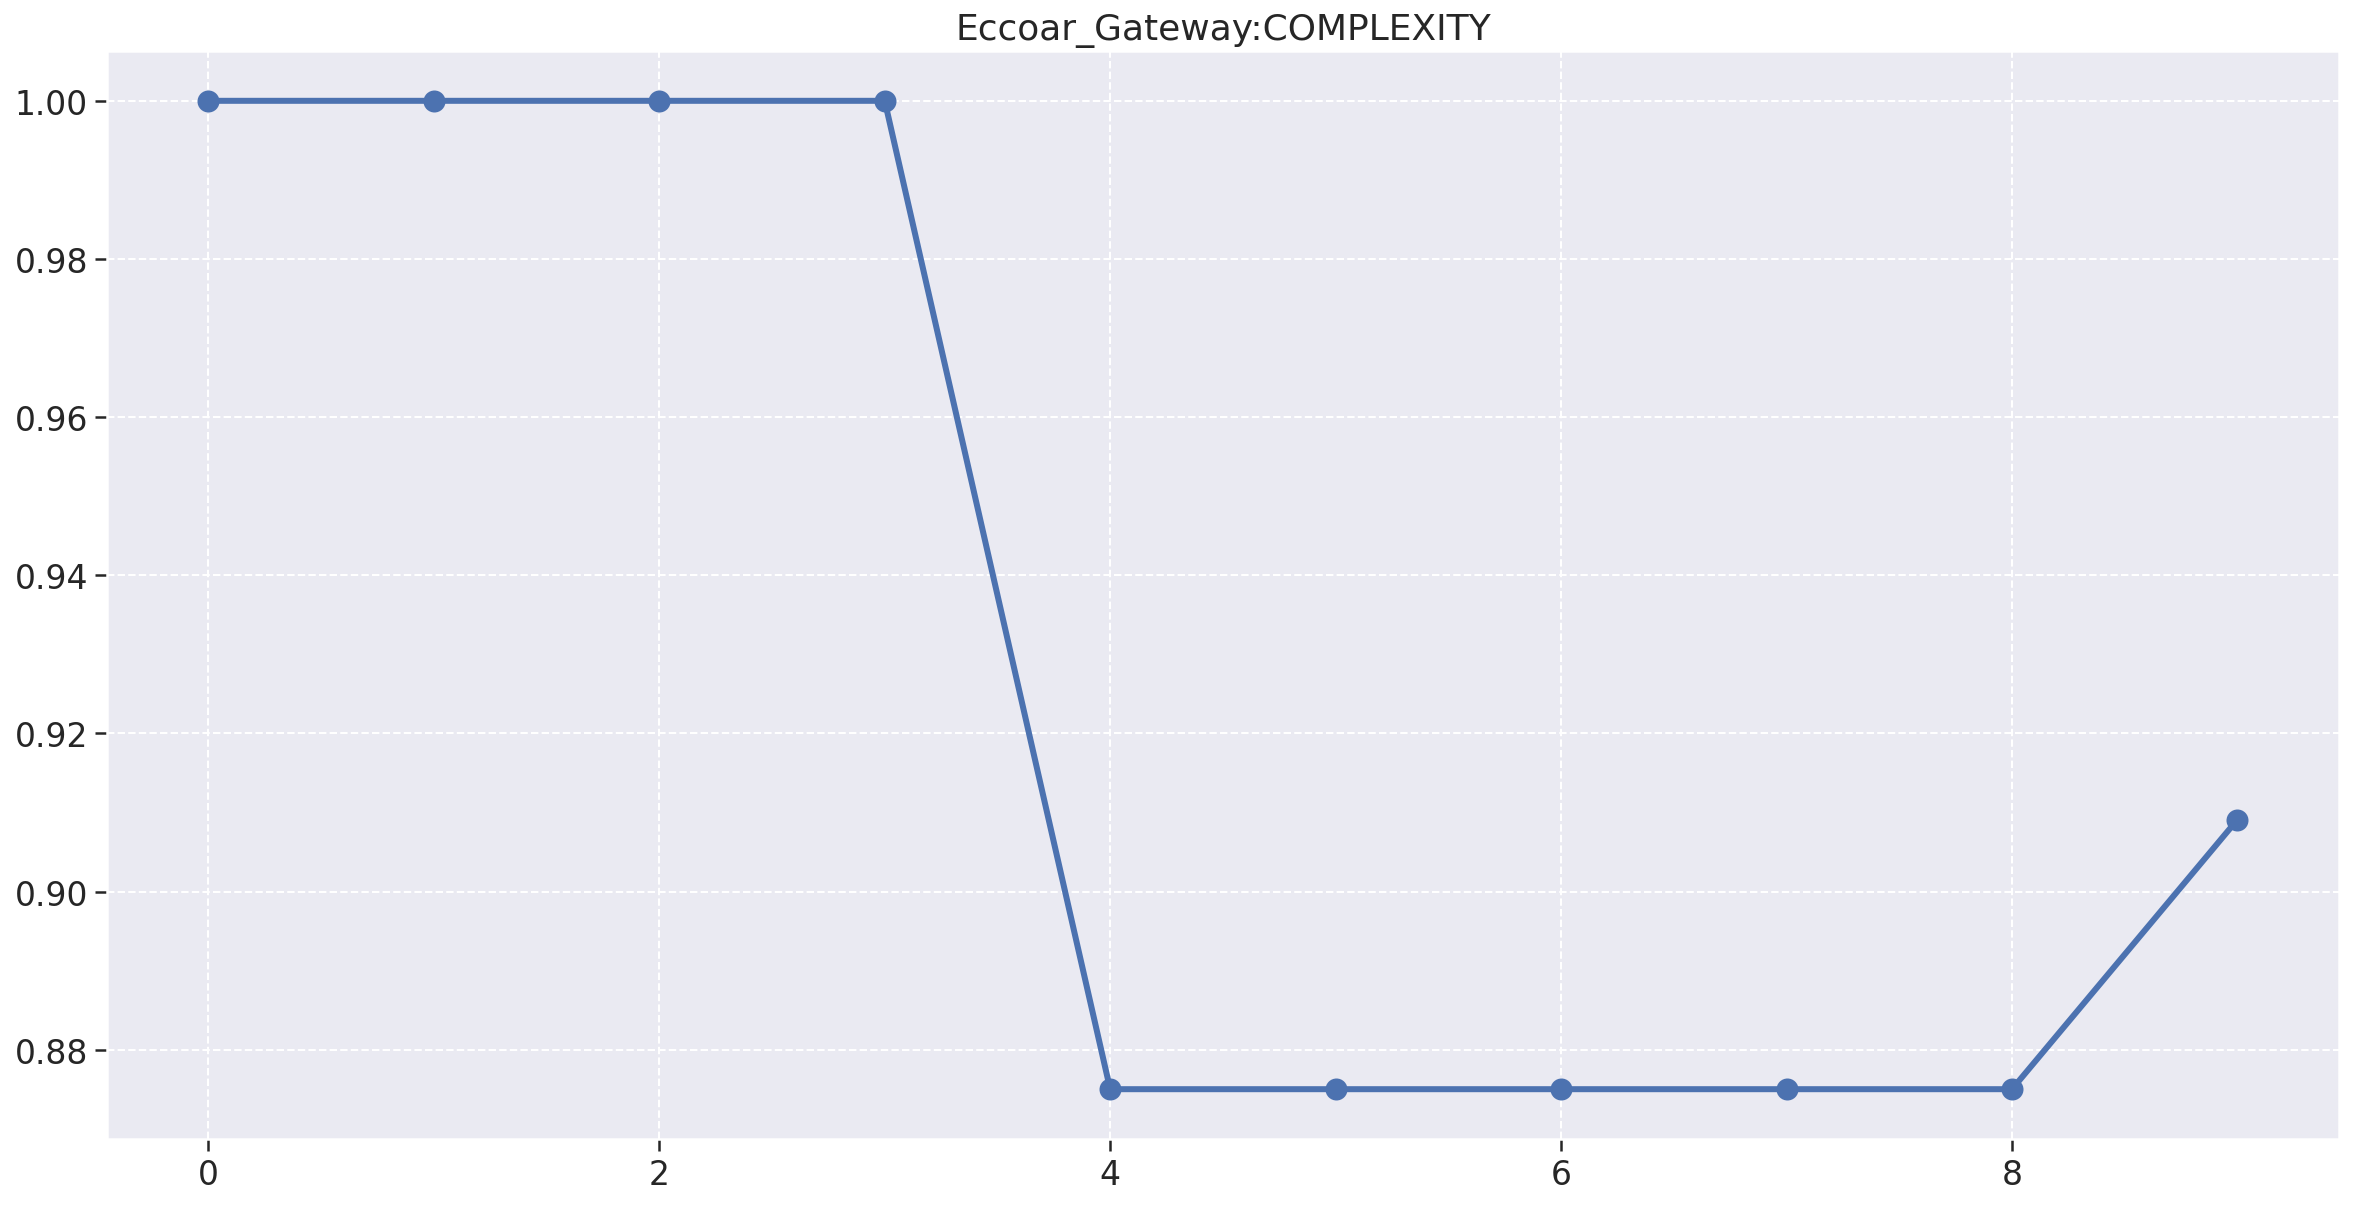

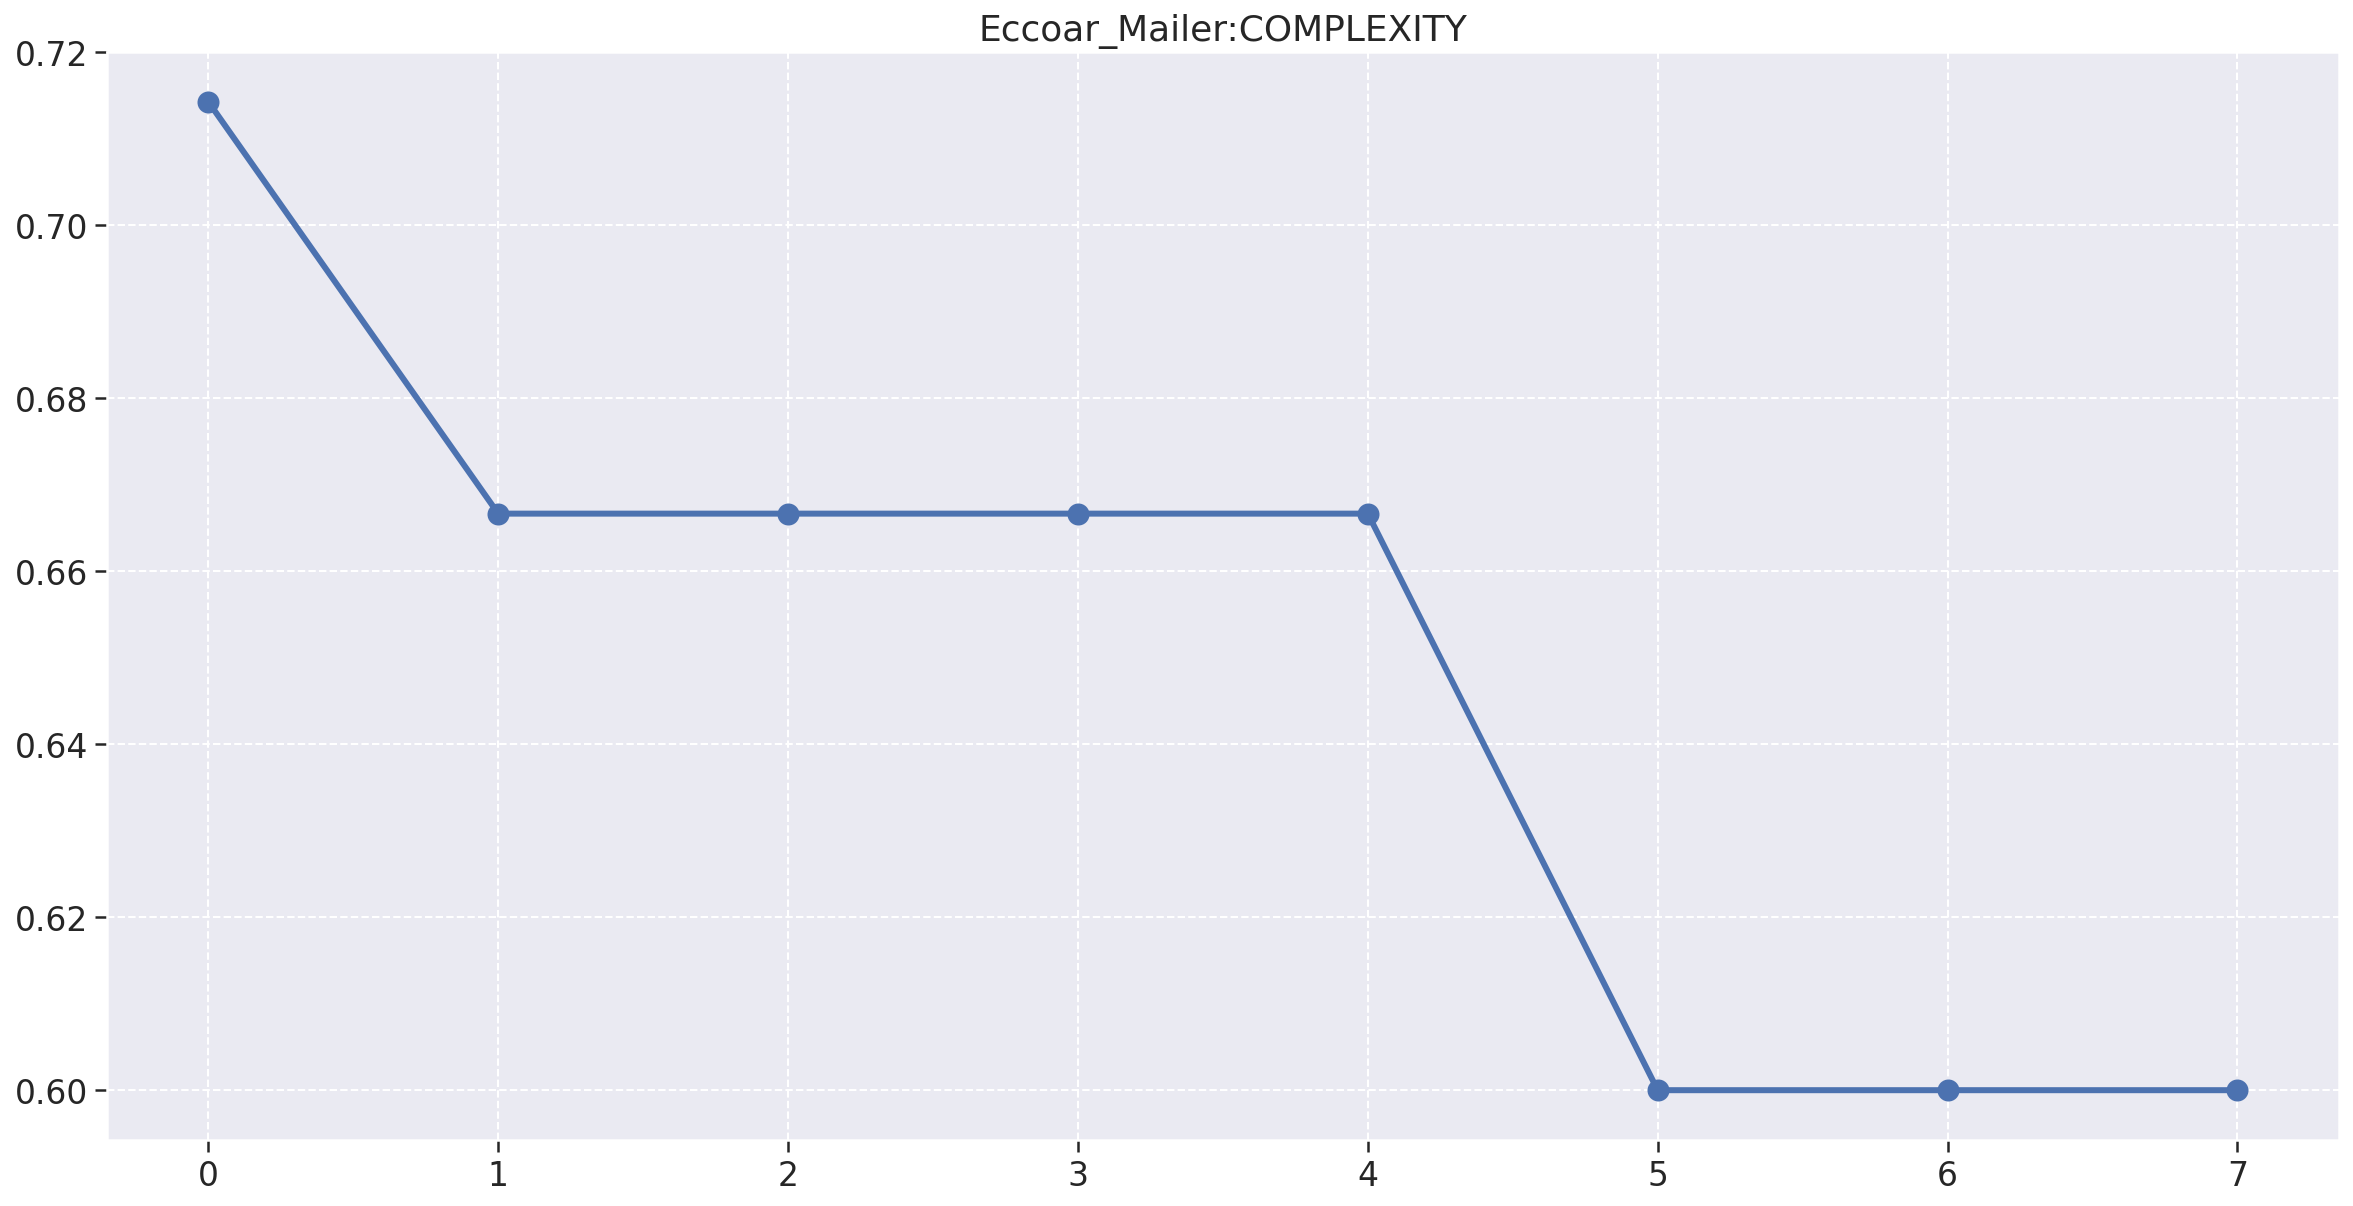

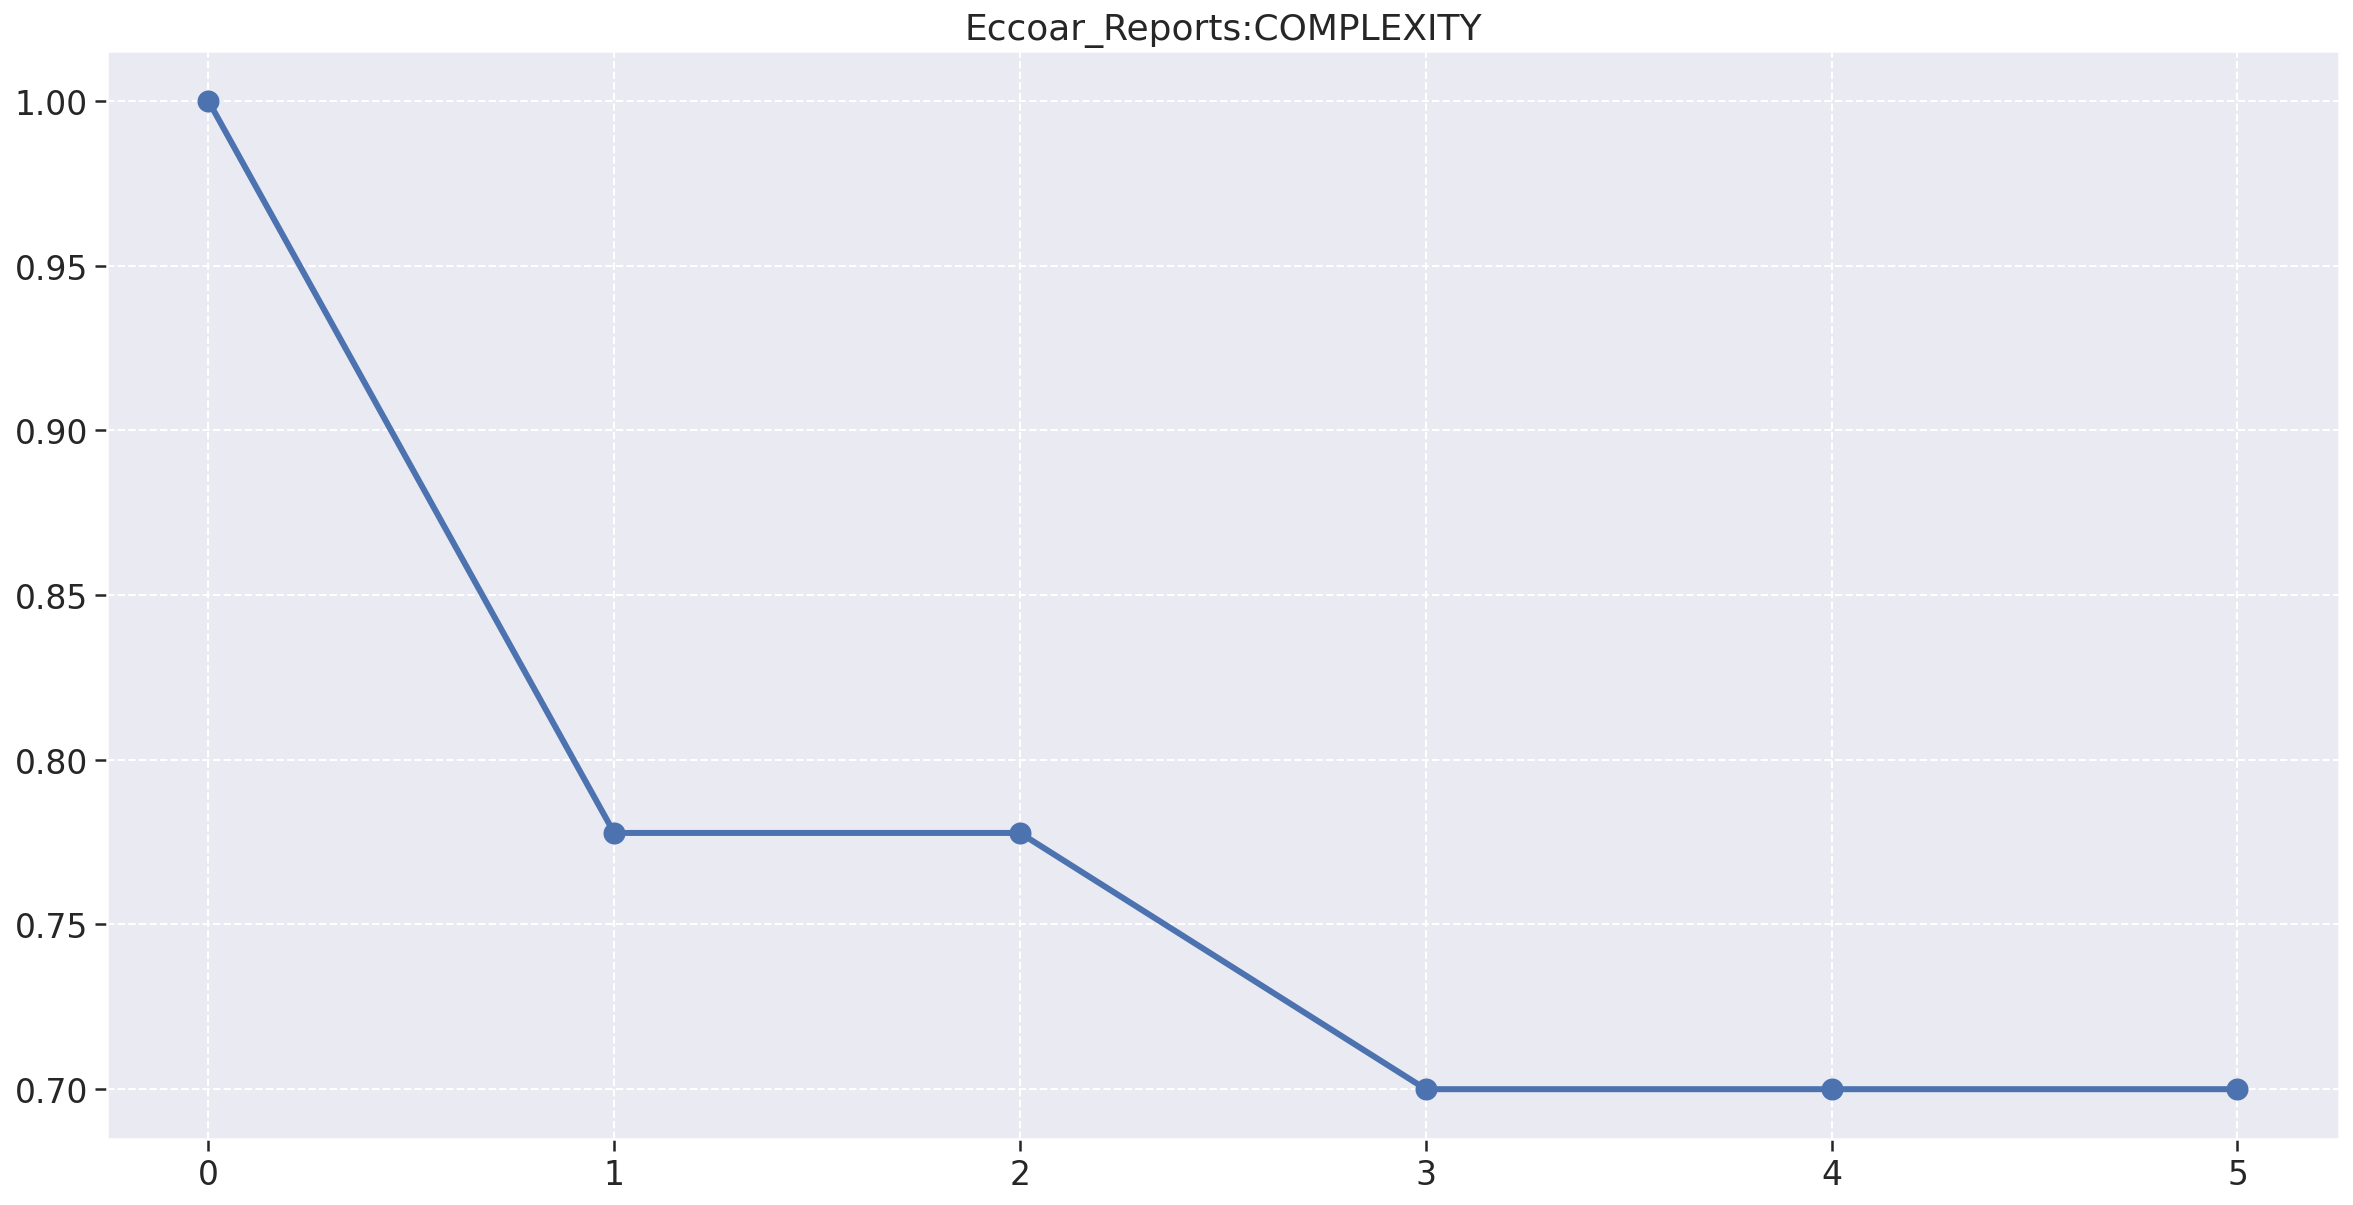

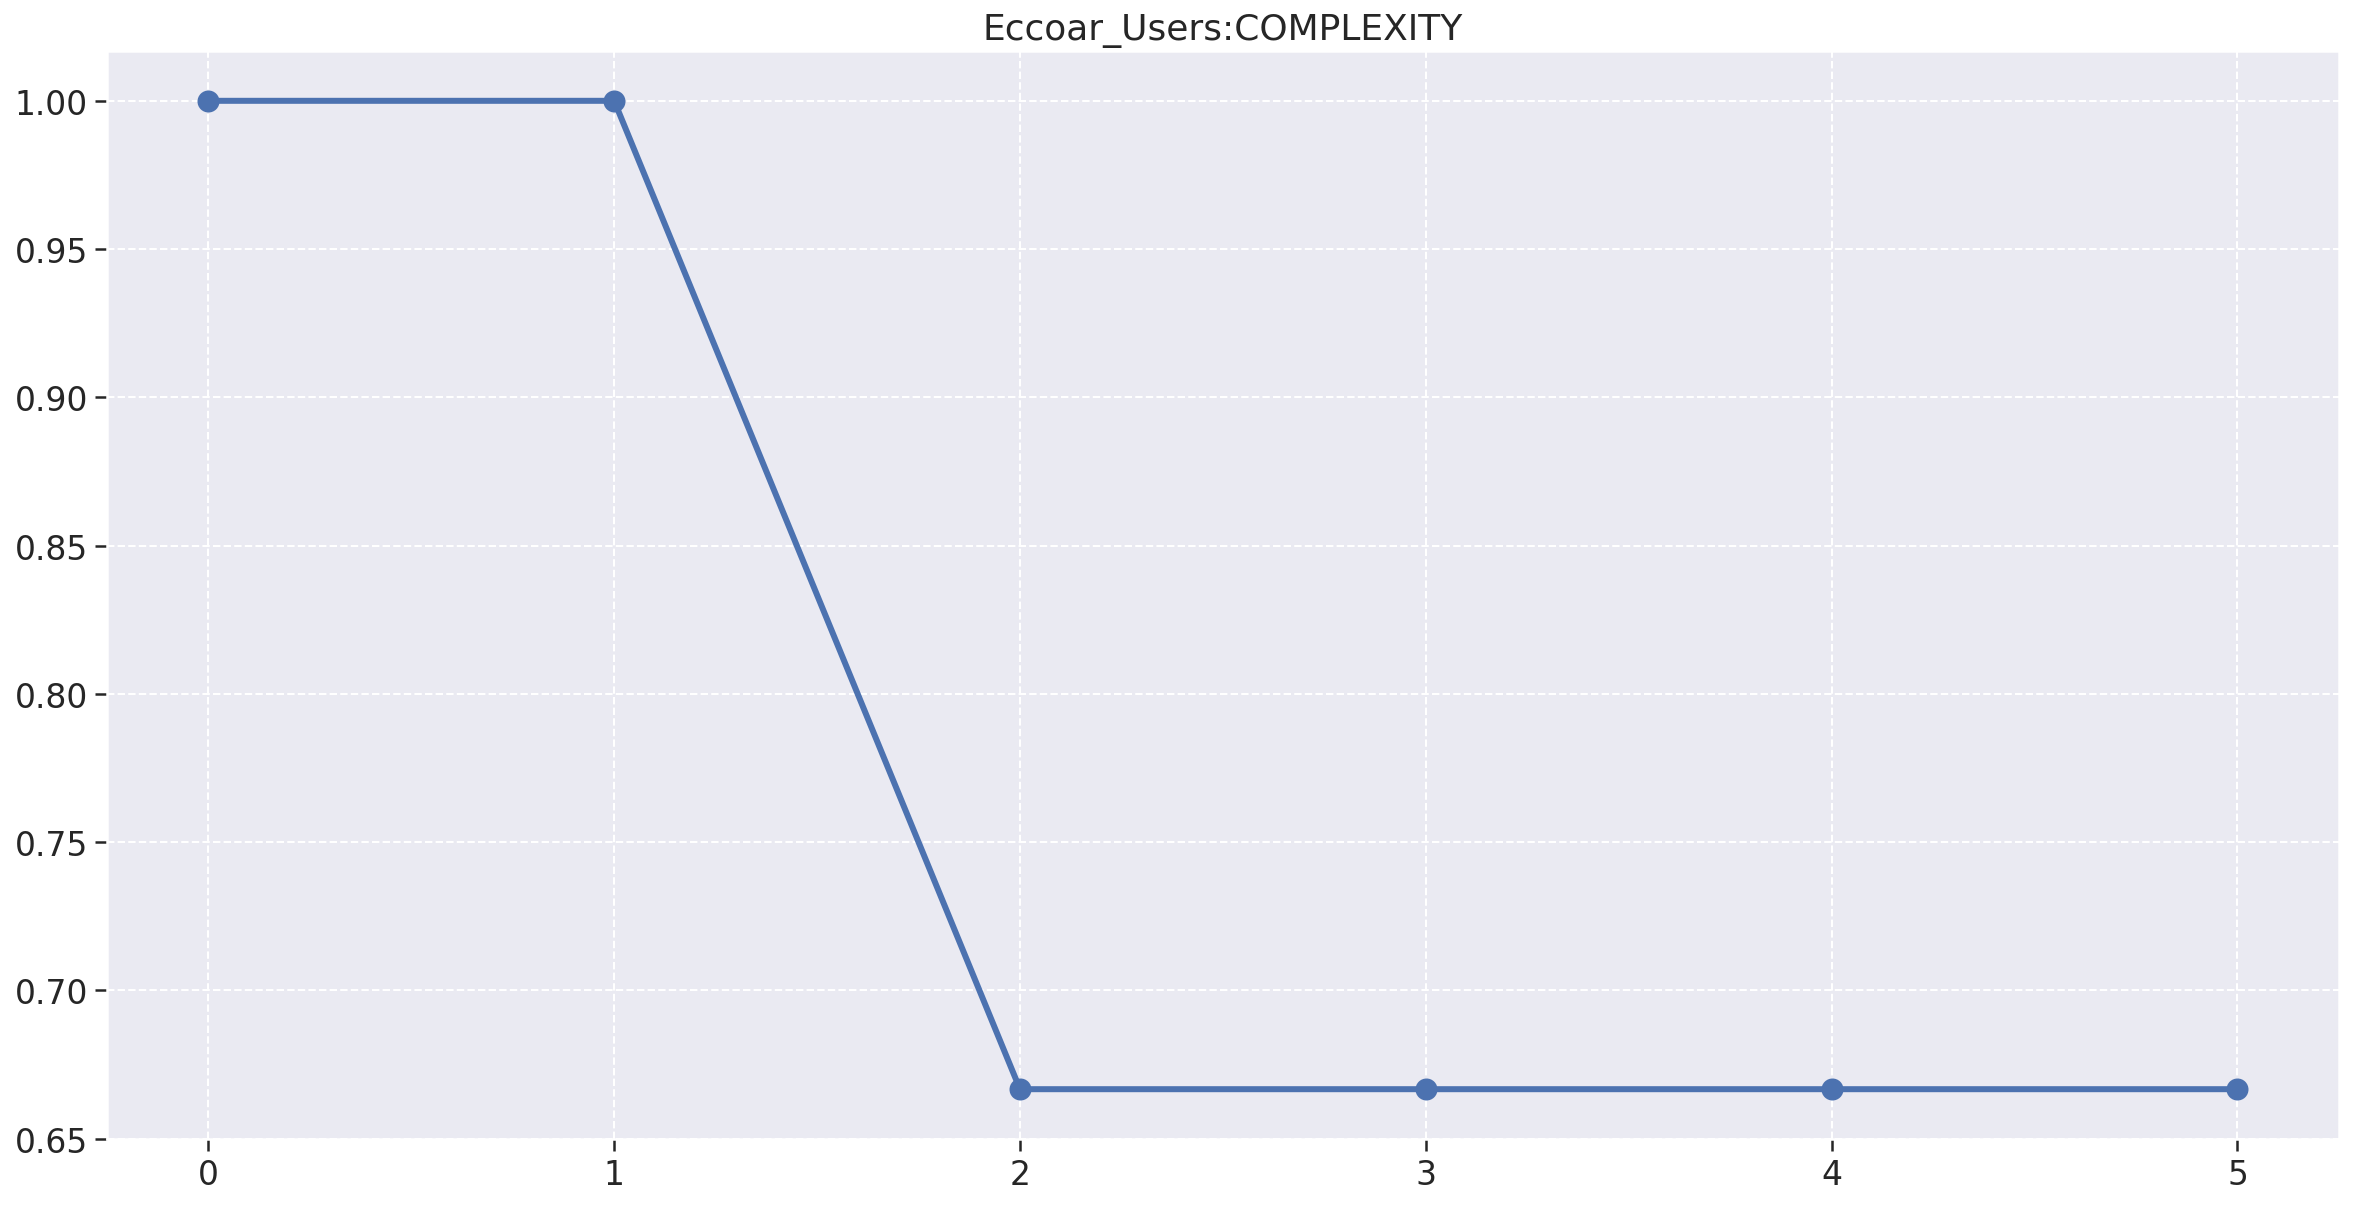

In [42]:

for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'], linewidth=3, marker='o', markersize=10)

## Comments

### Os dados coletados a partir das métricas relacionadas 



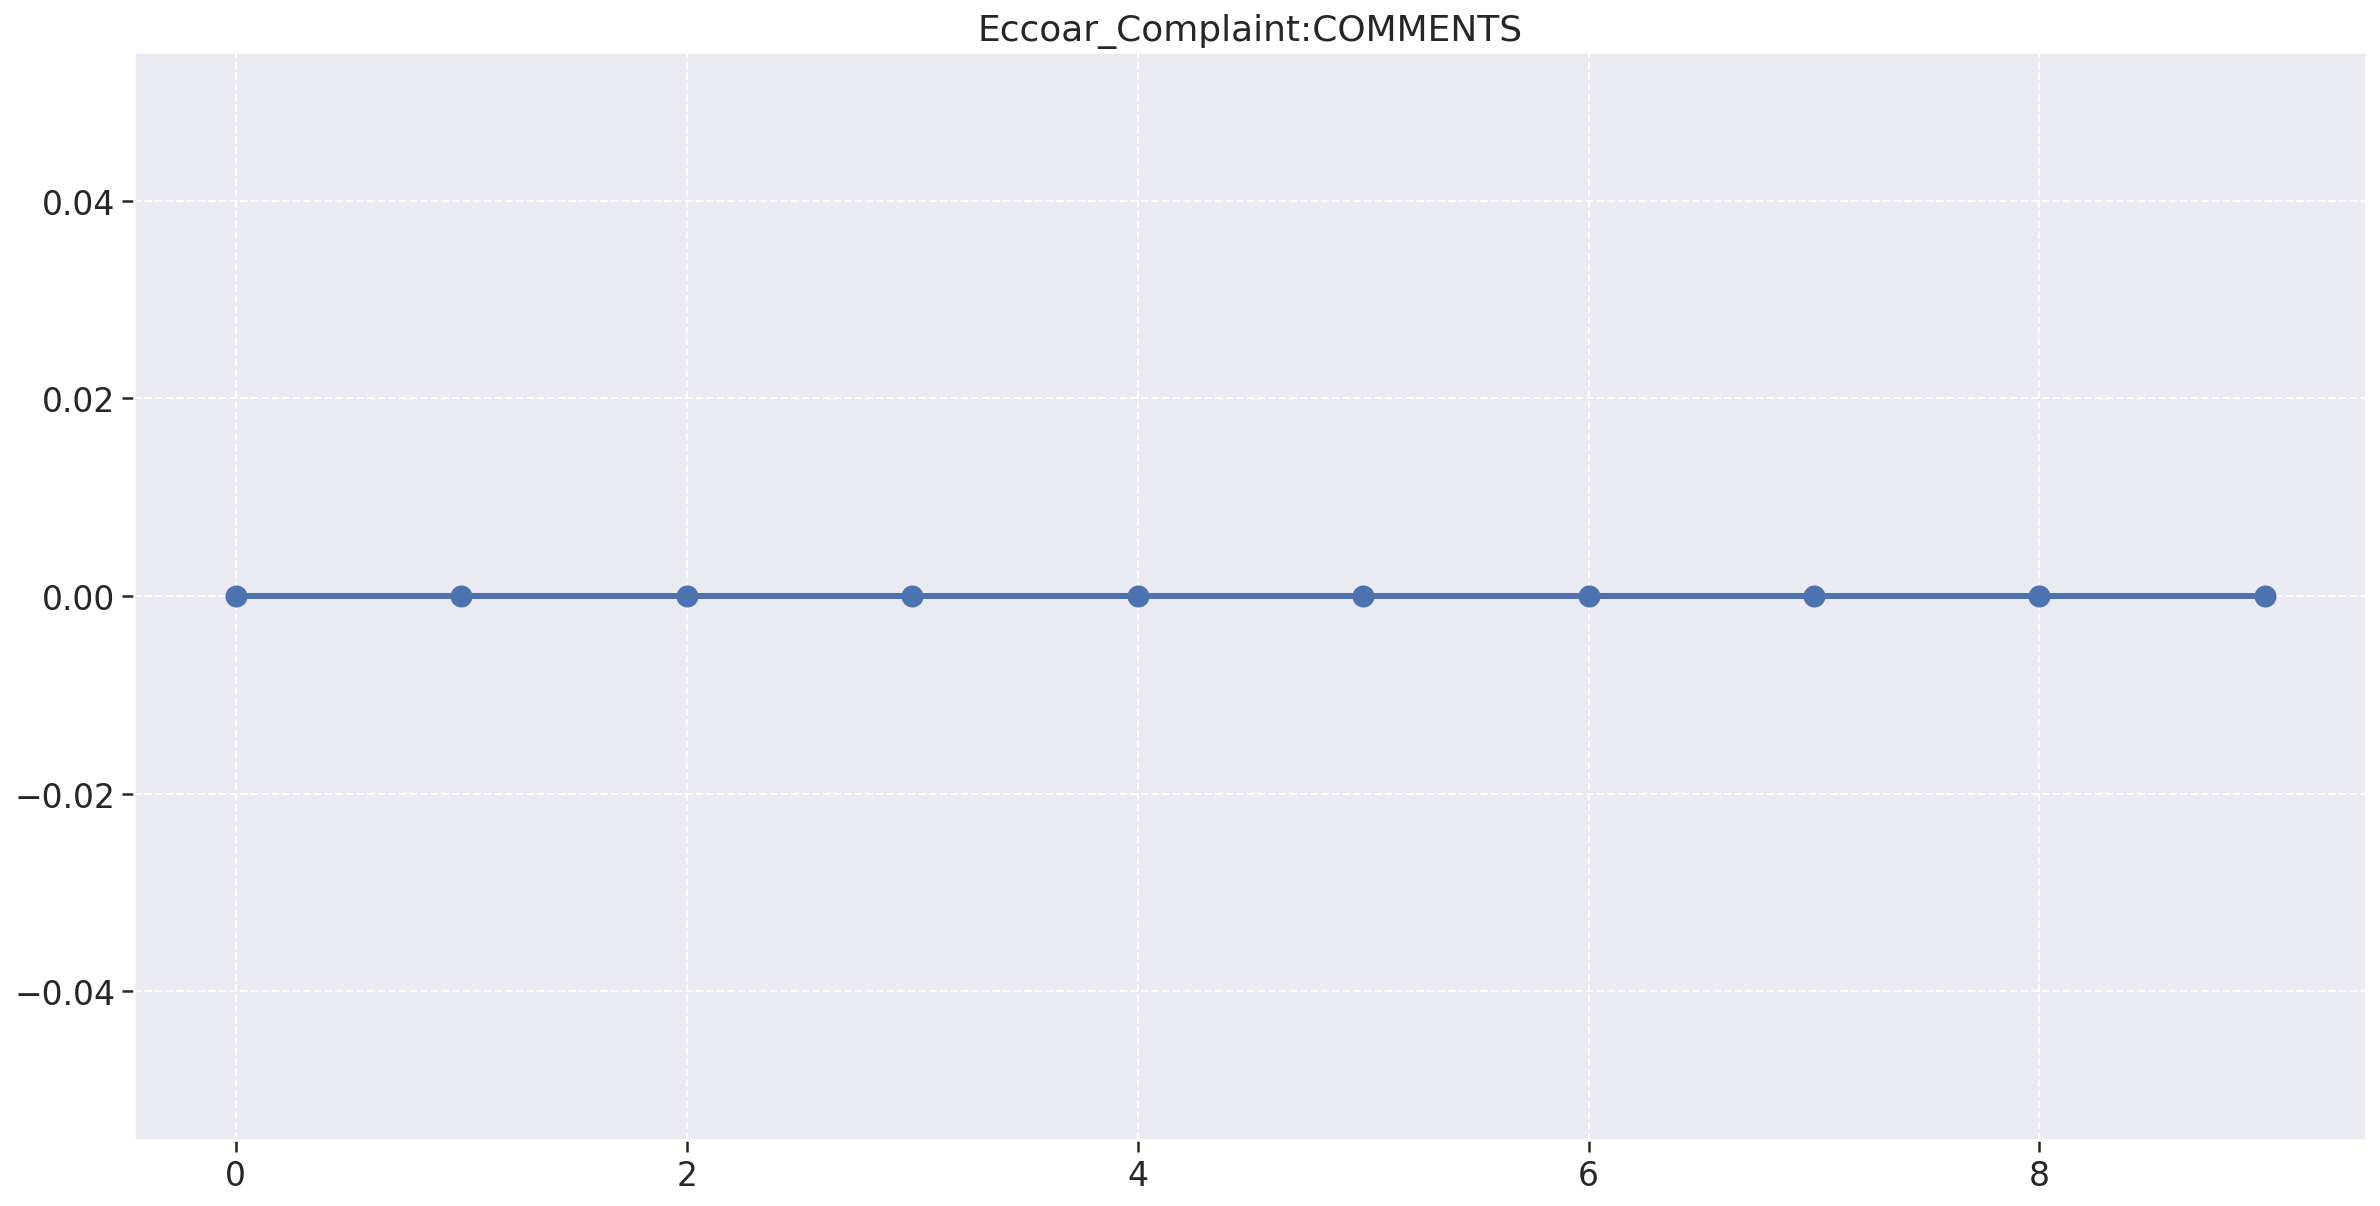

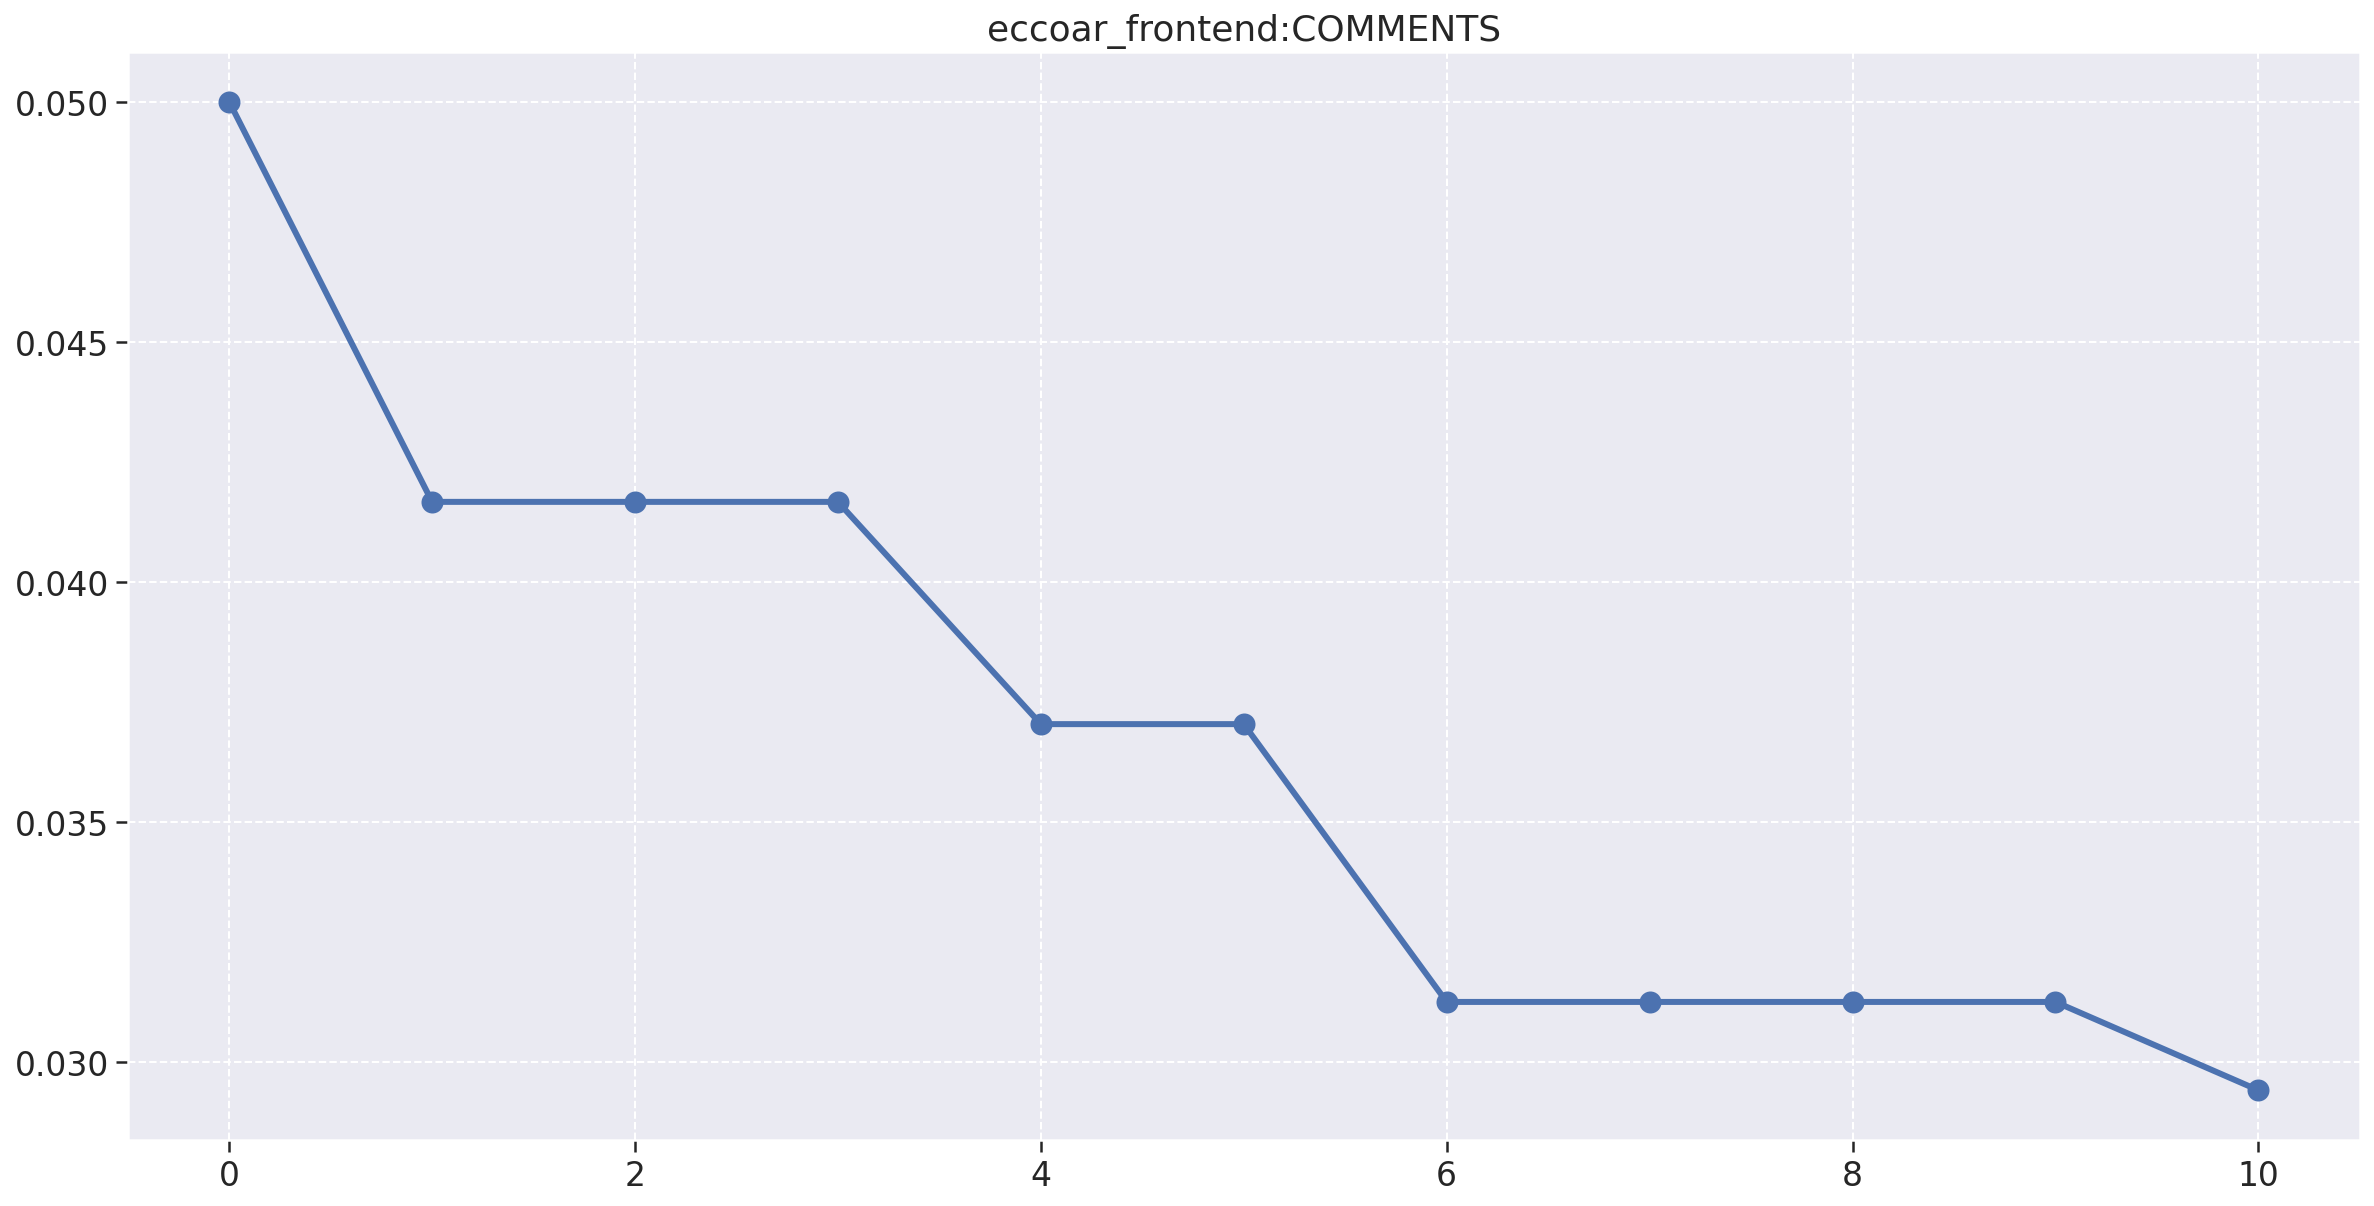

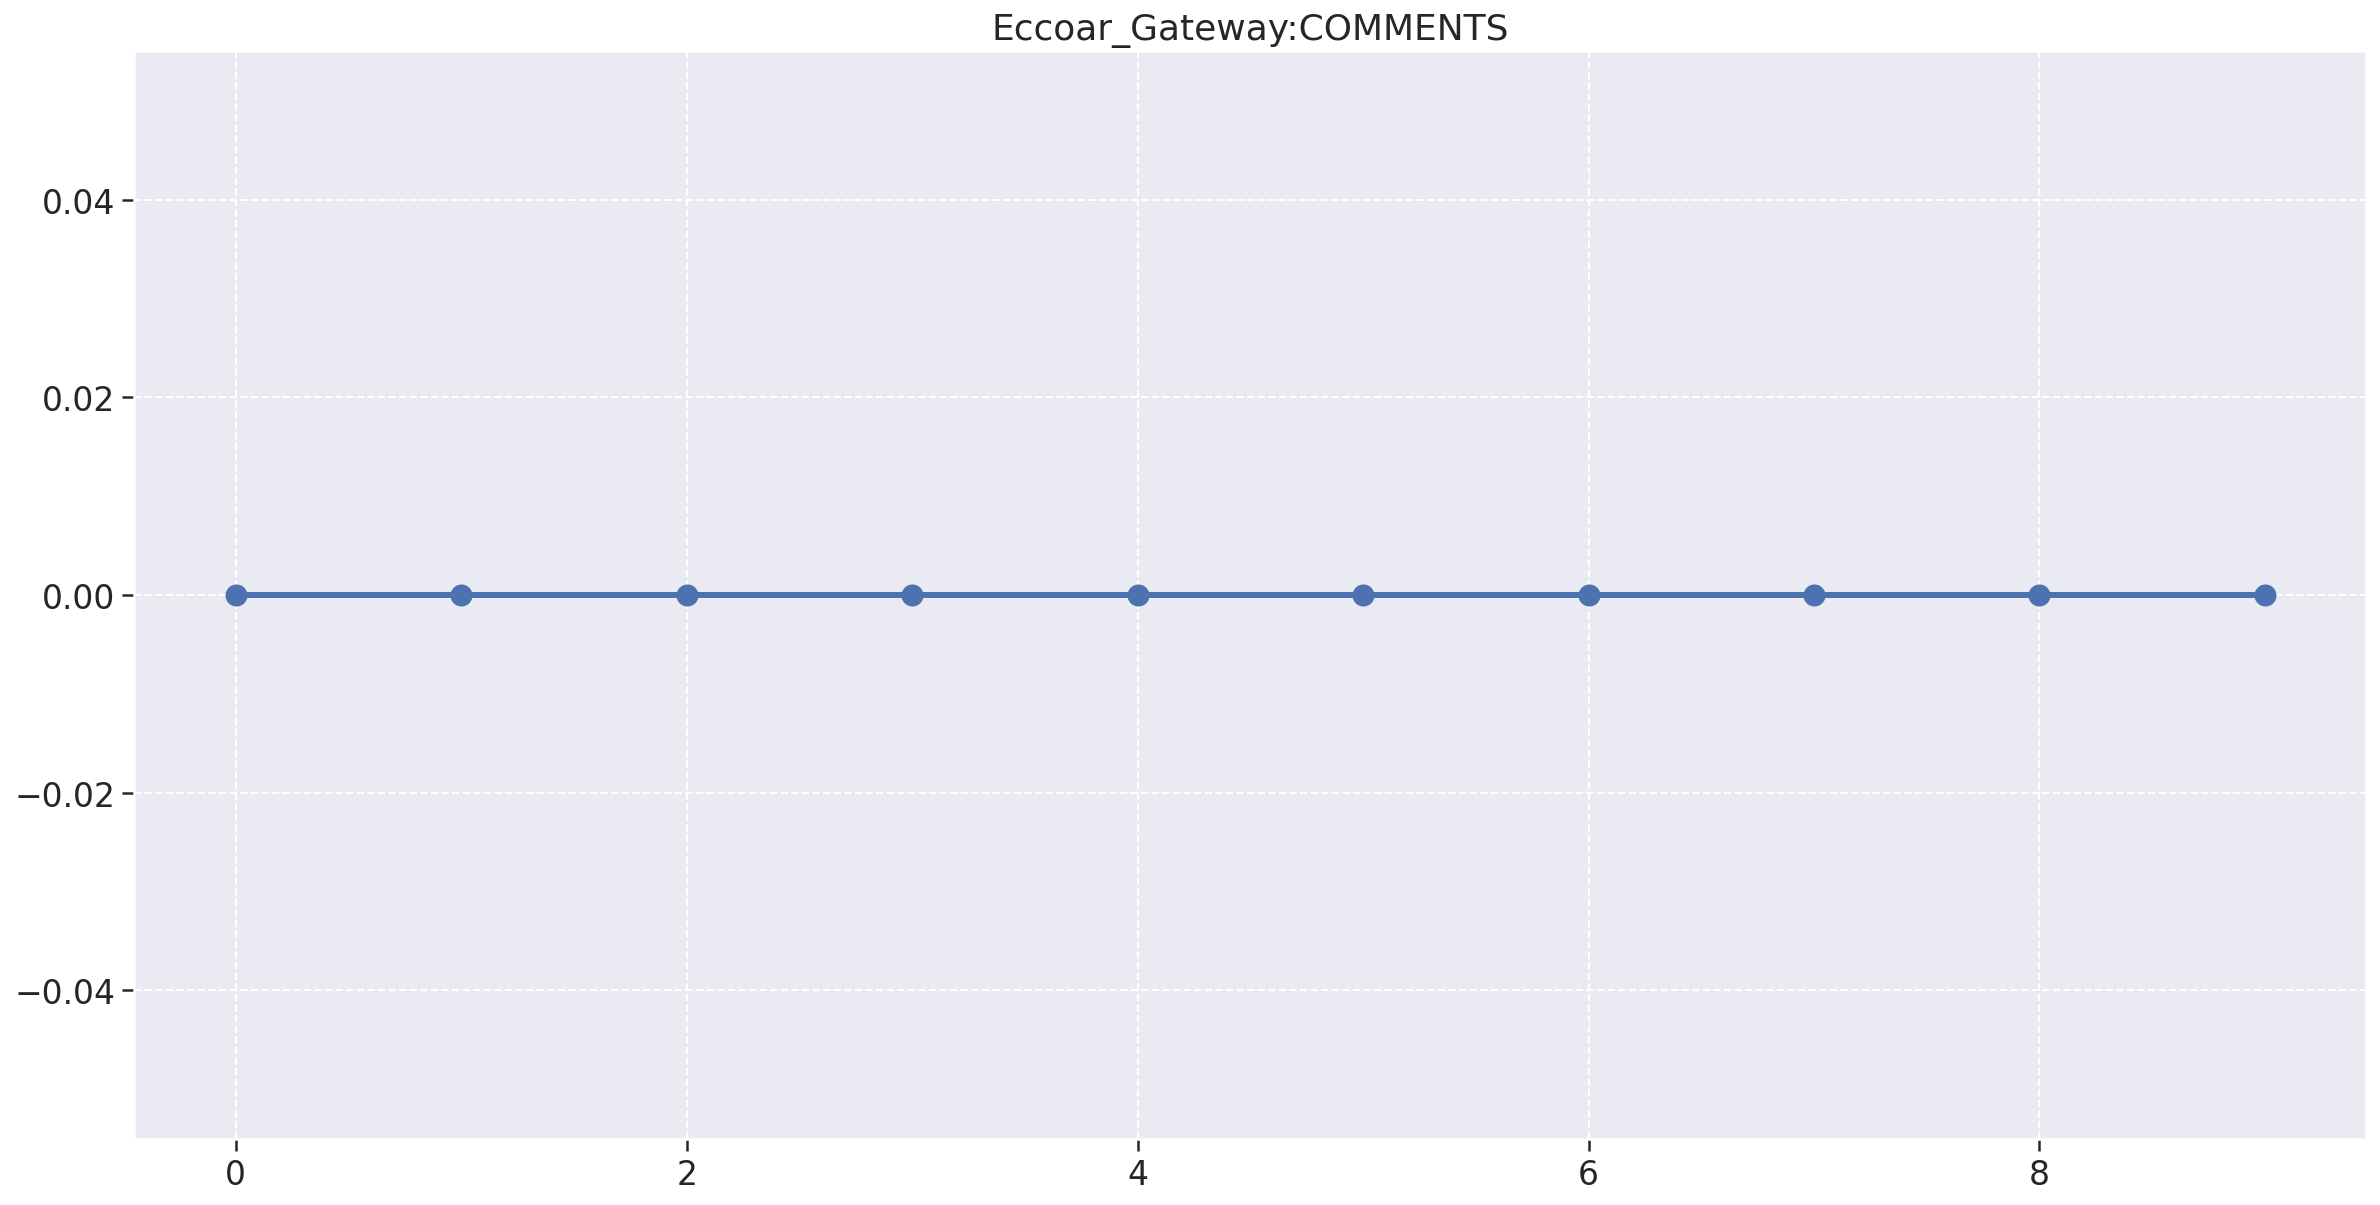

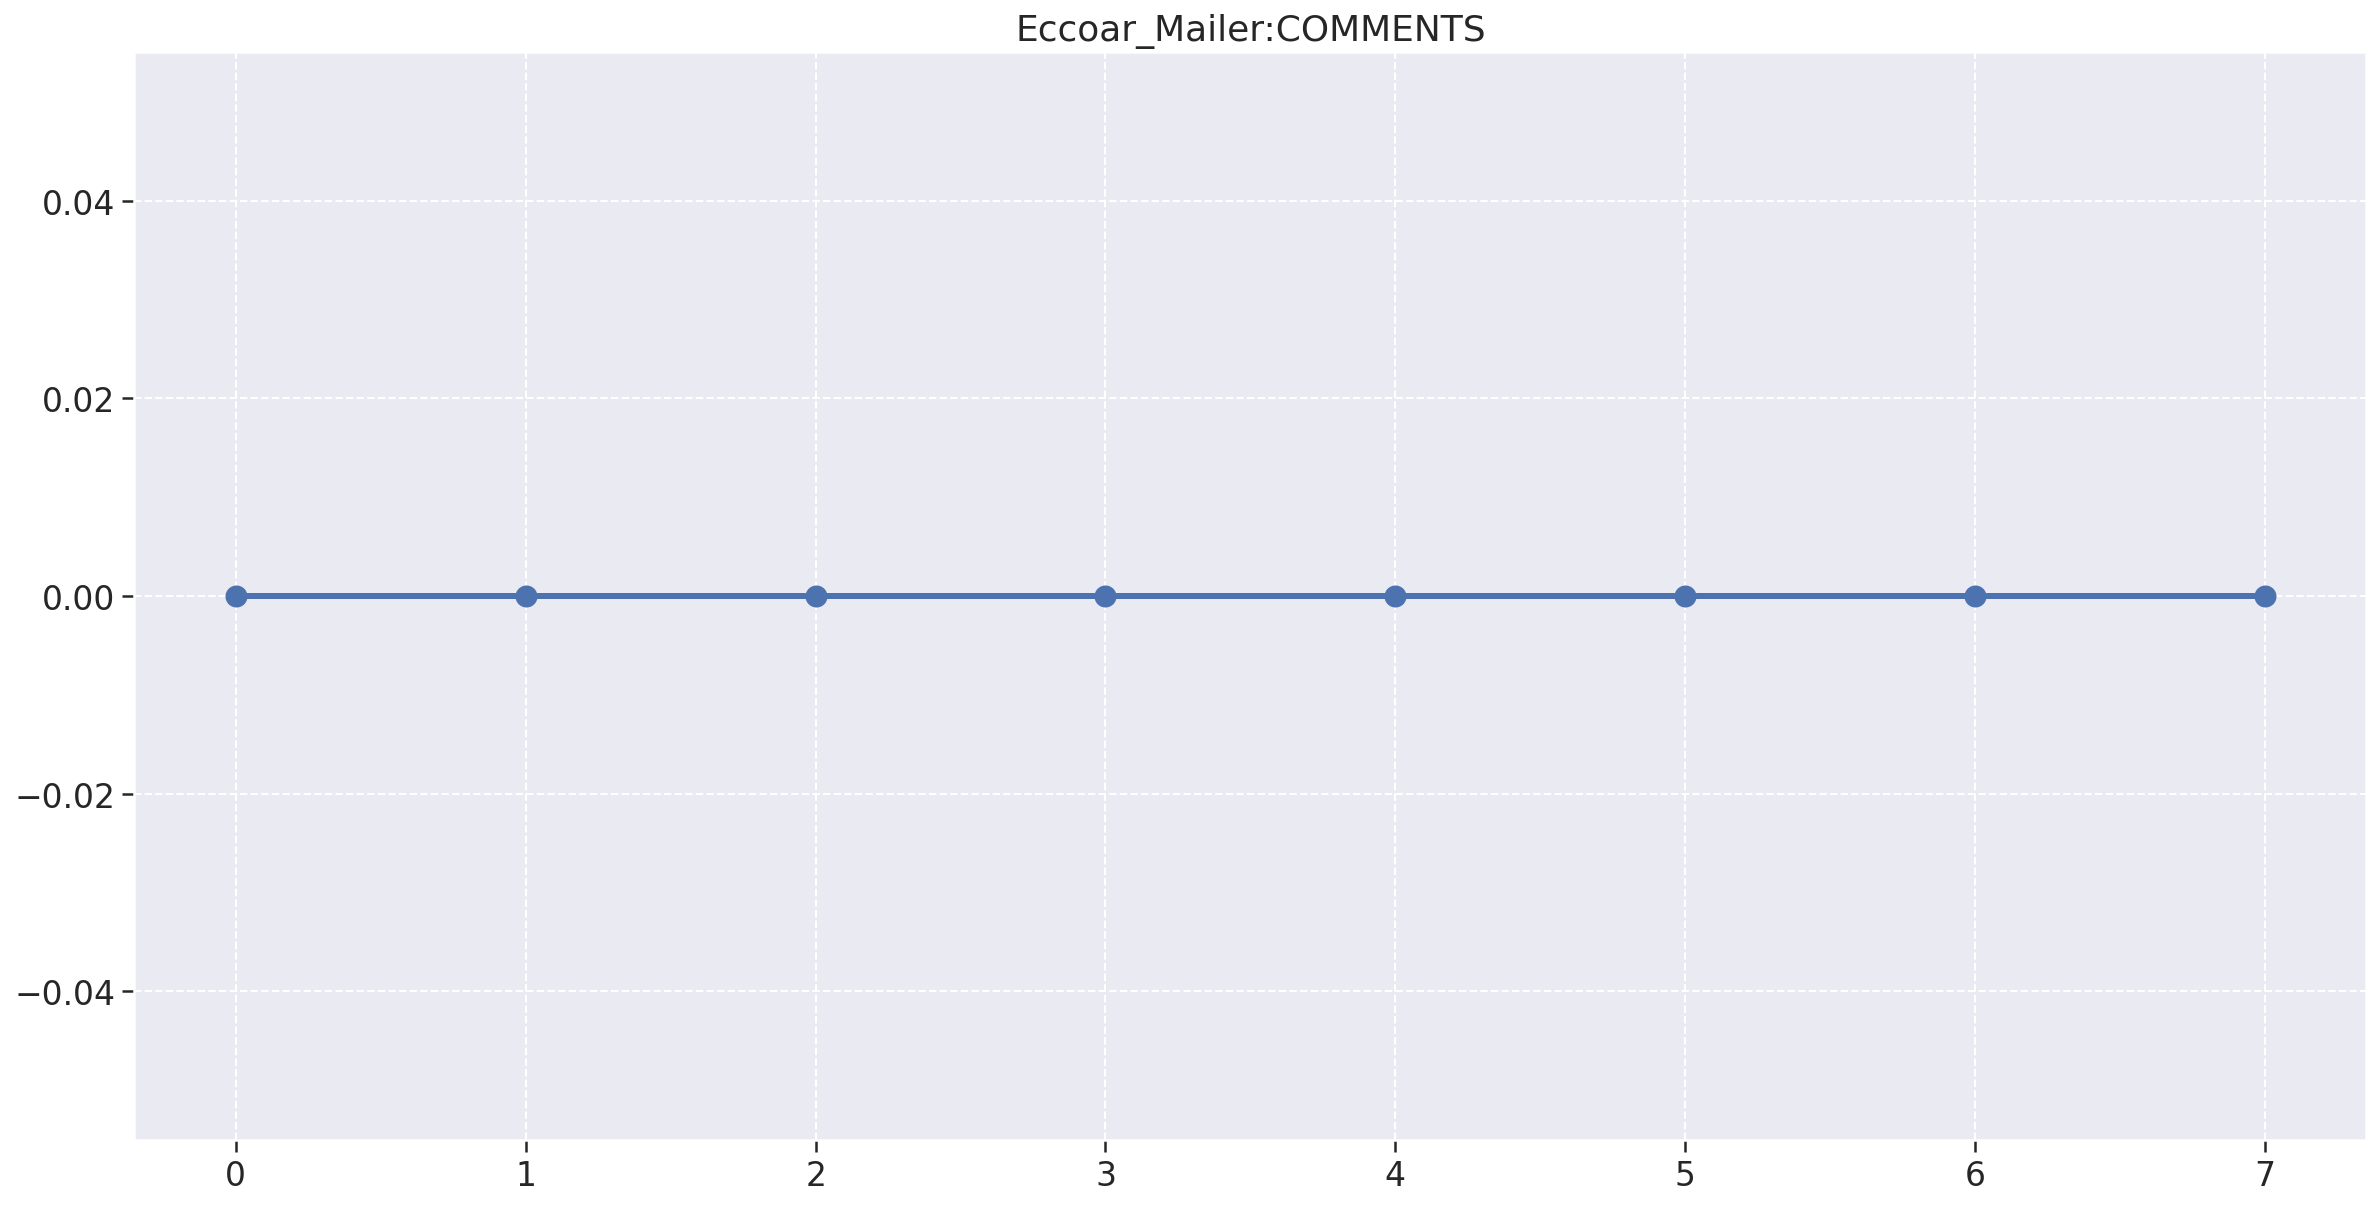

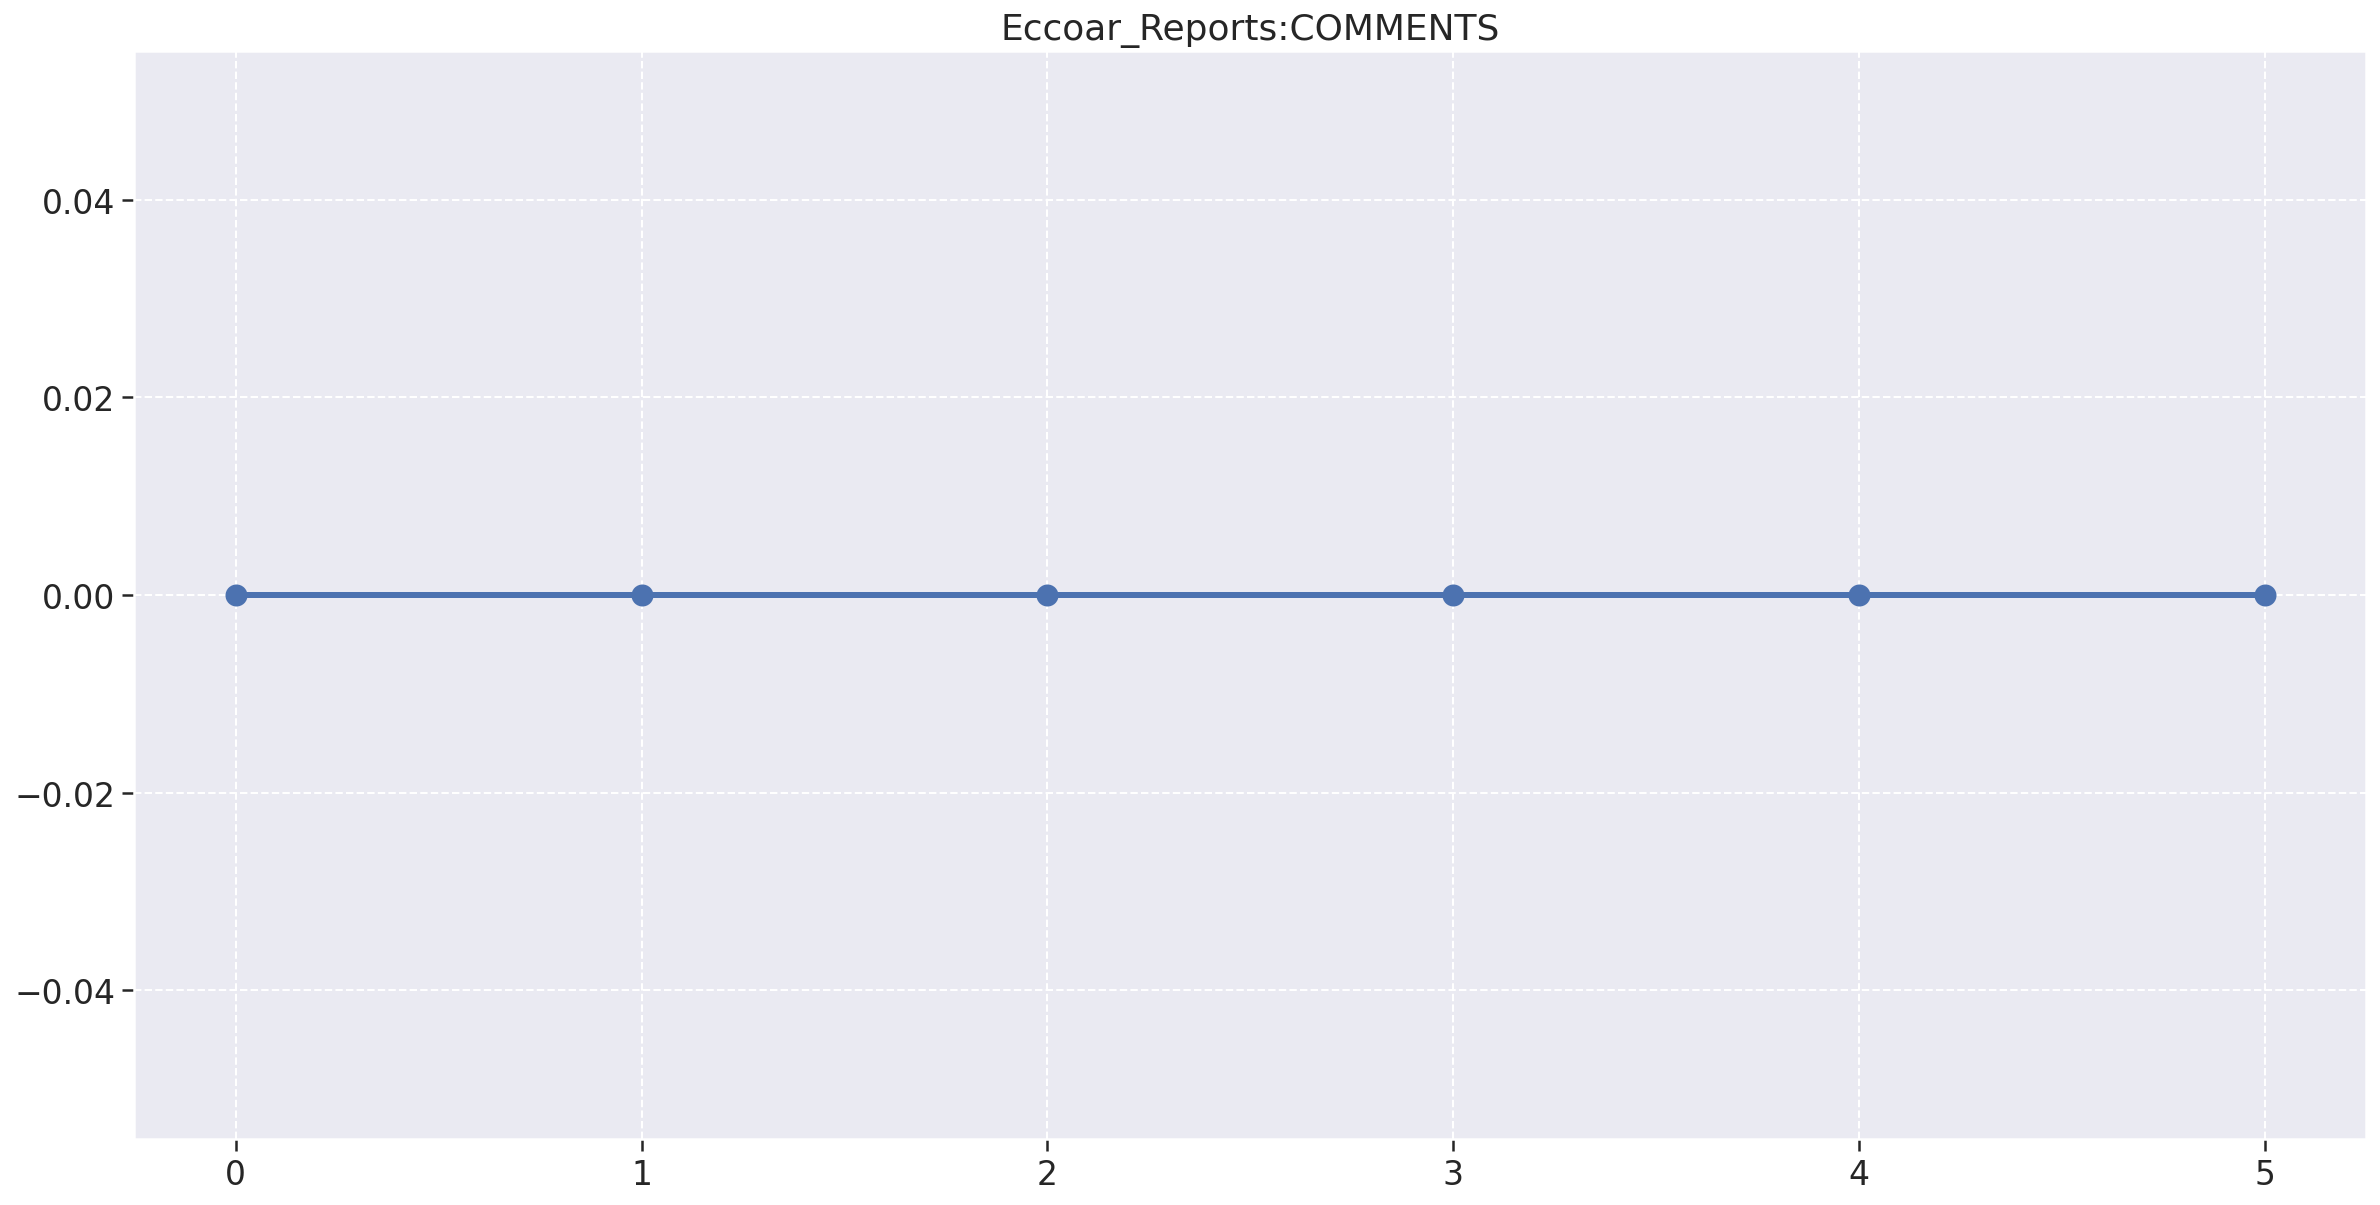

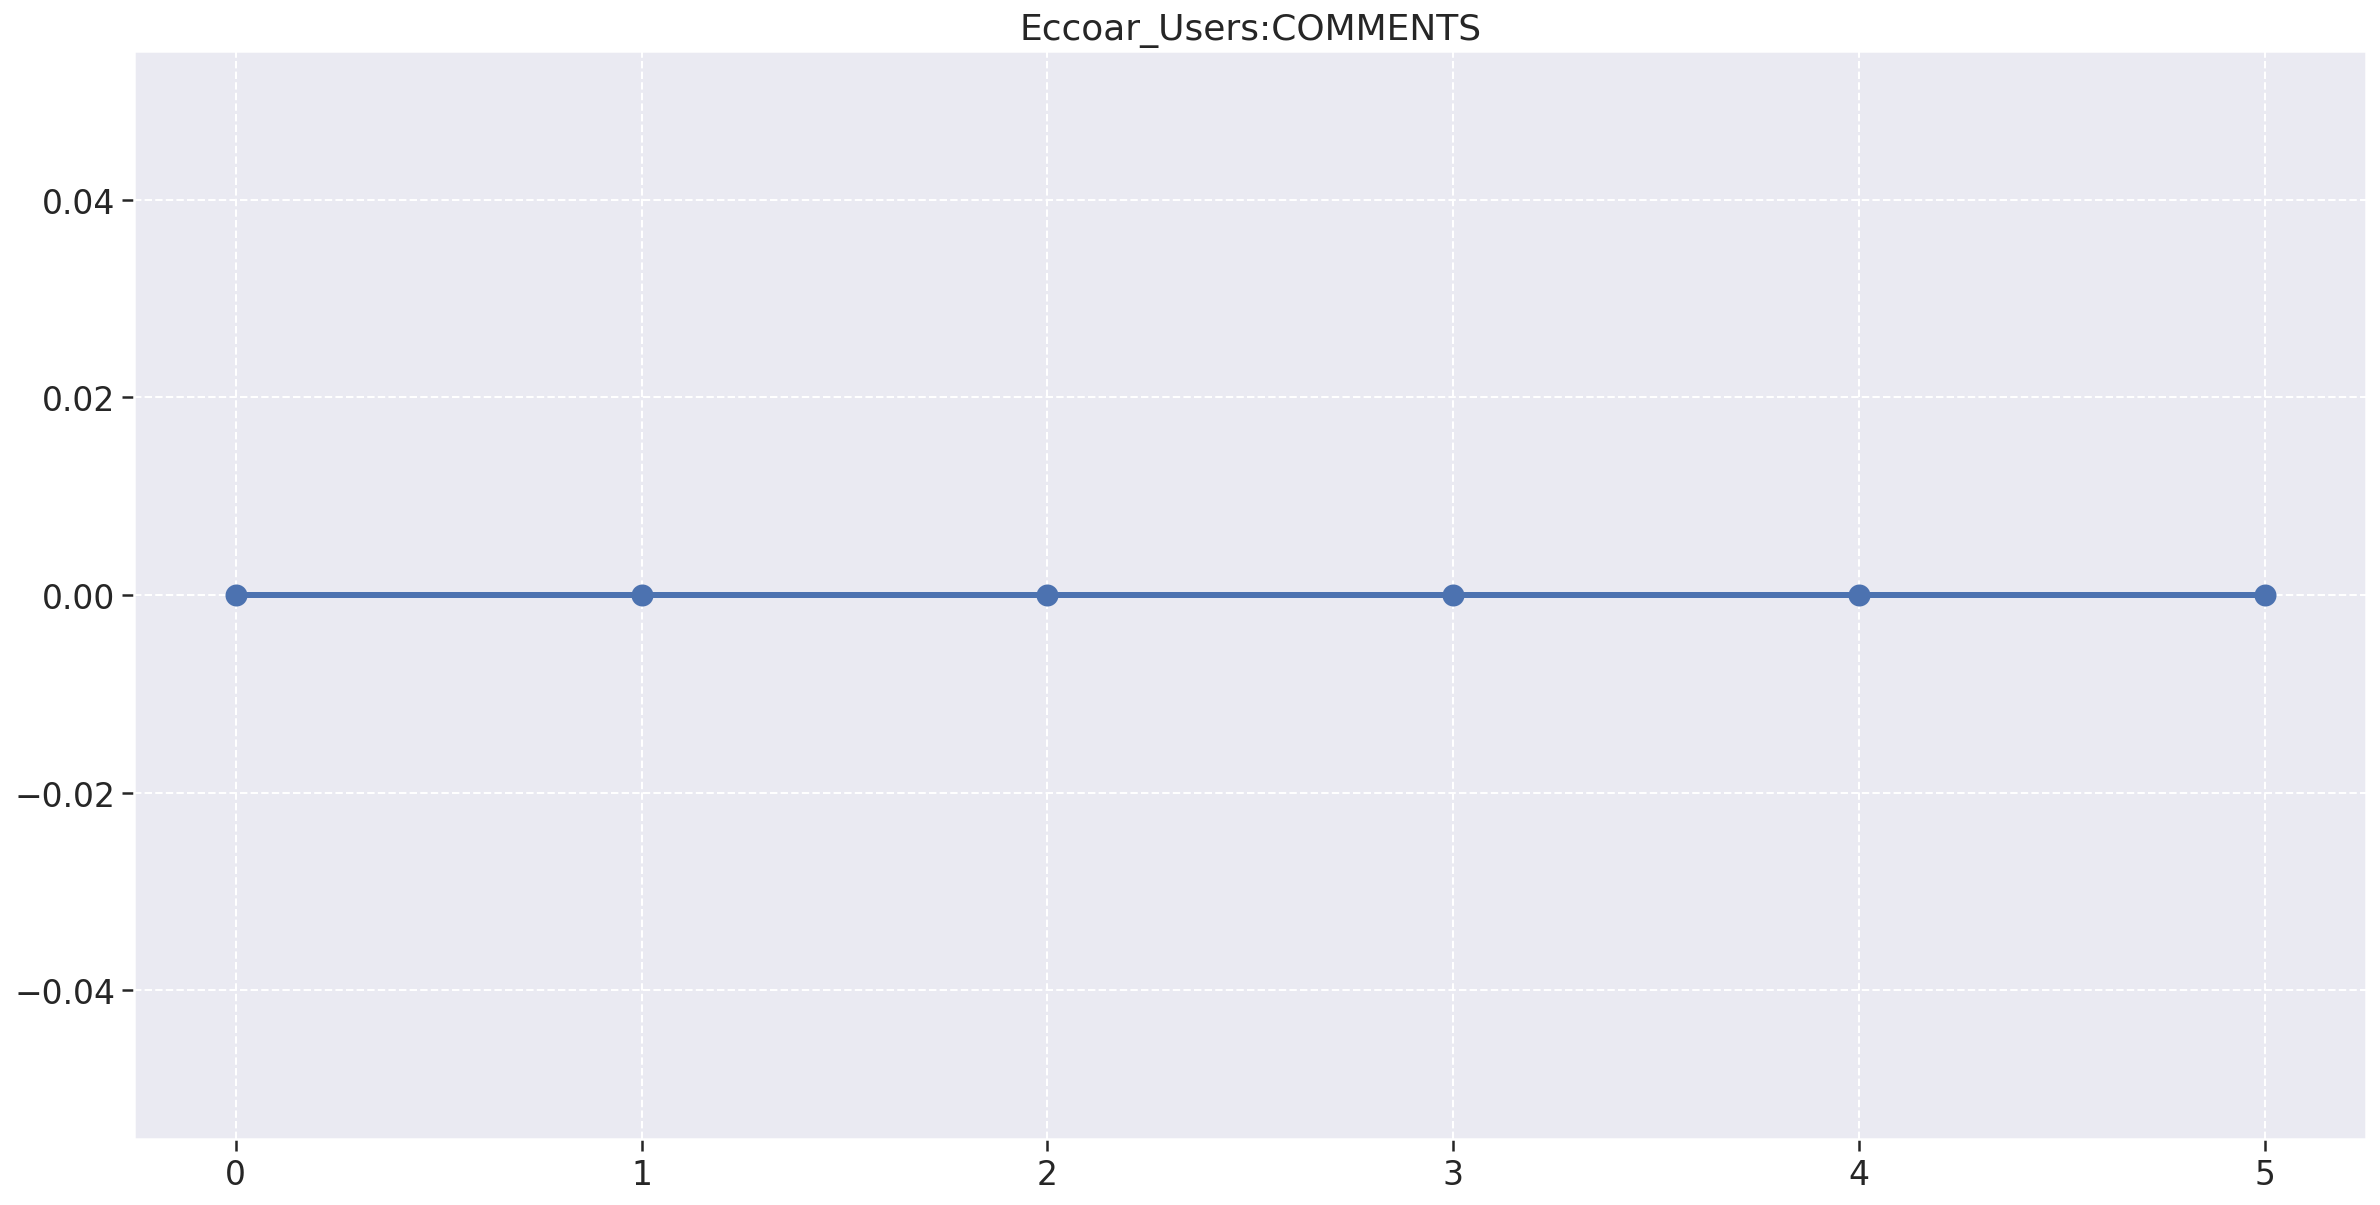

In [43]:

for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(metrics_df['m2'], linewidth=3, marker='o', markersize=10)

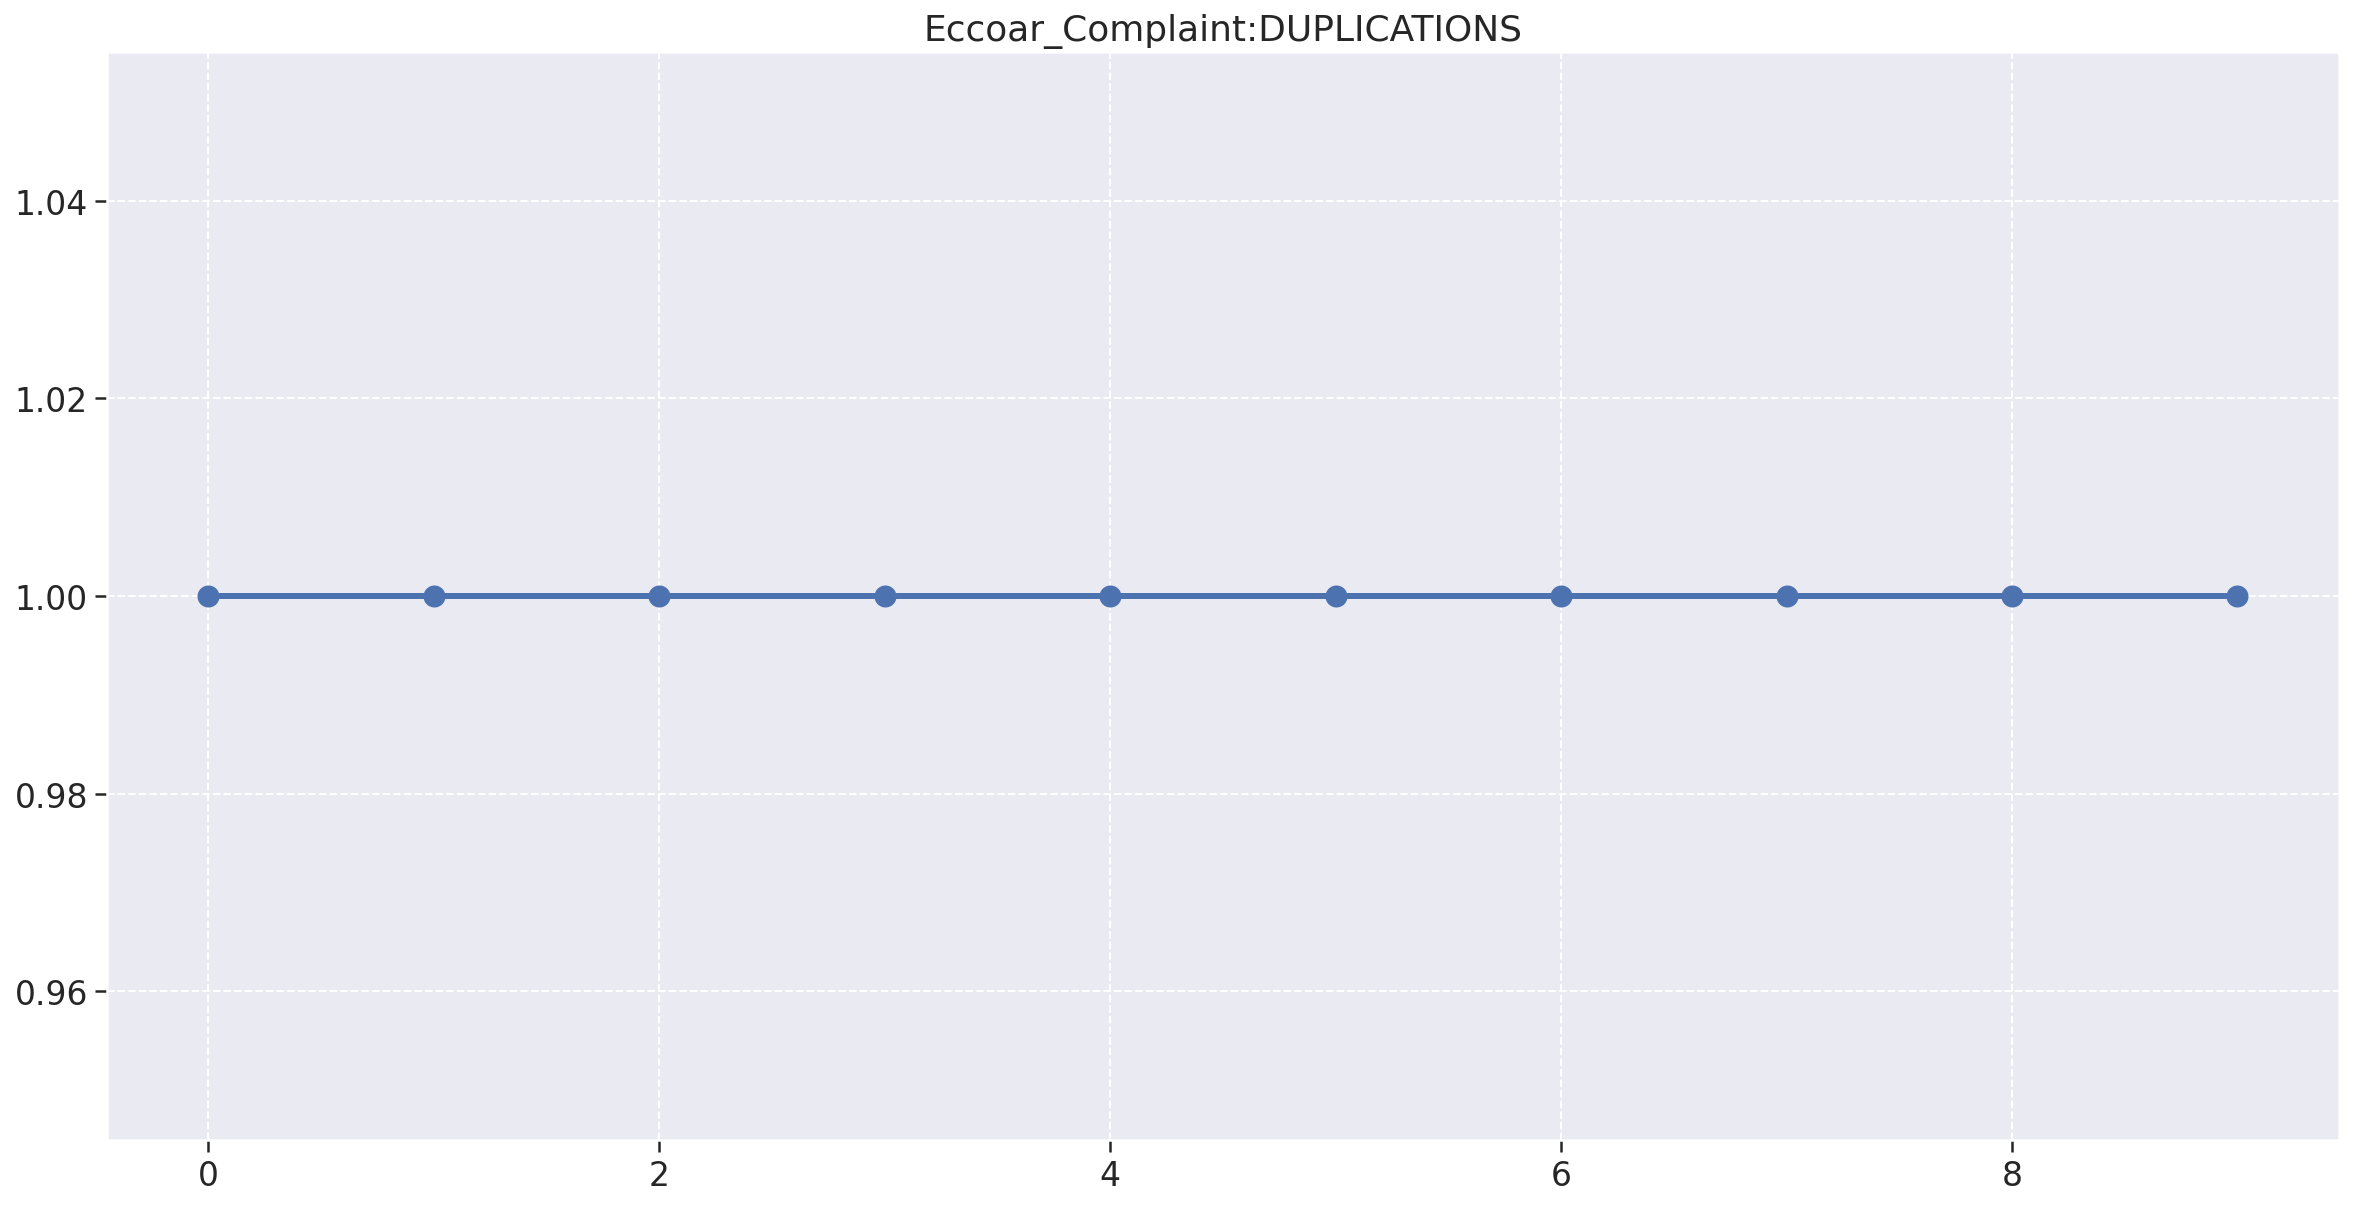

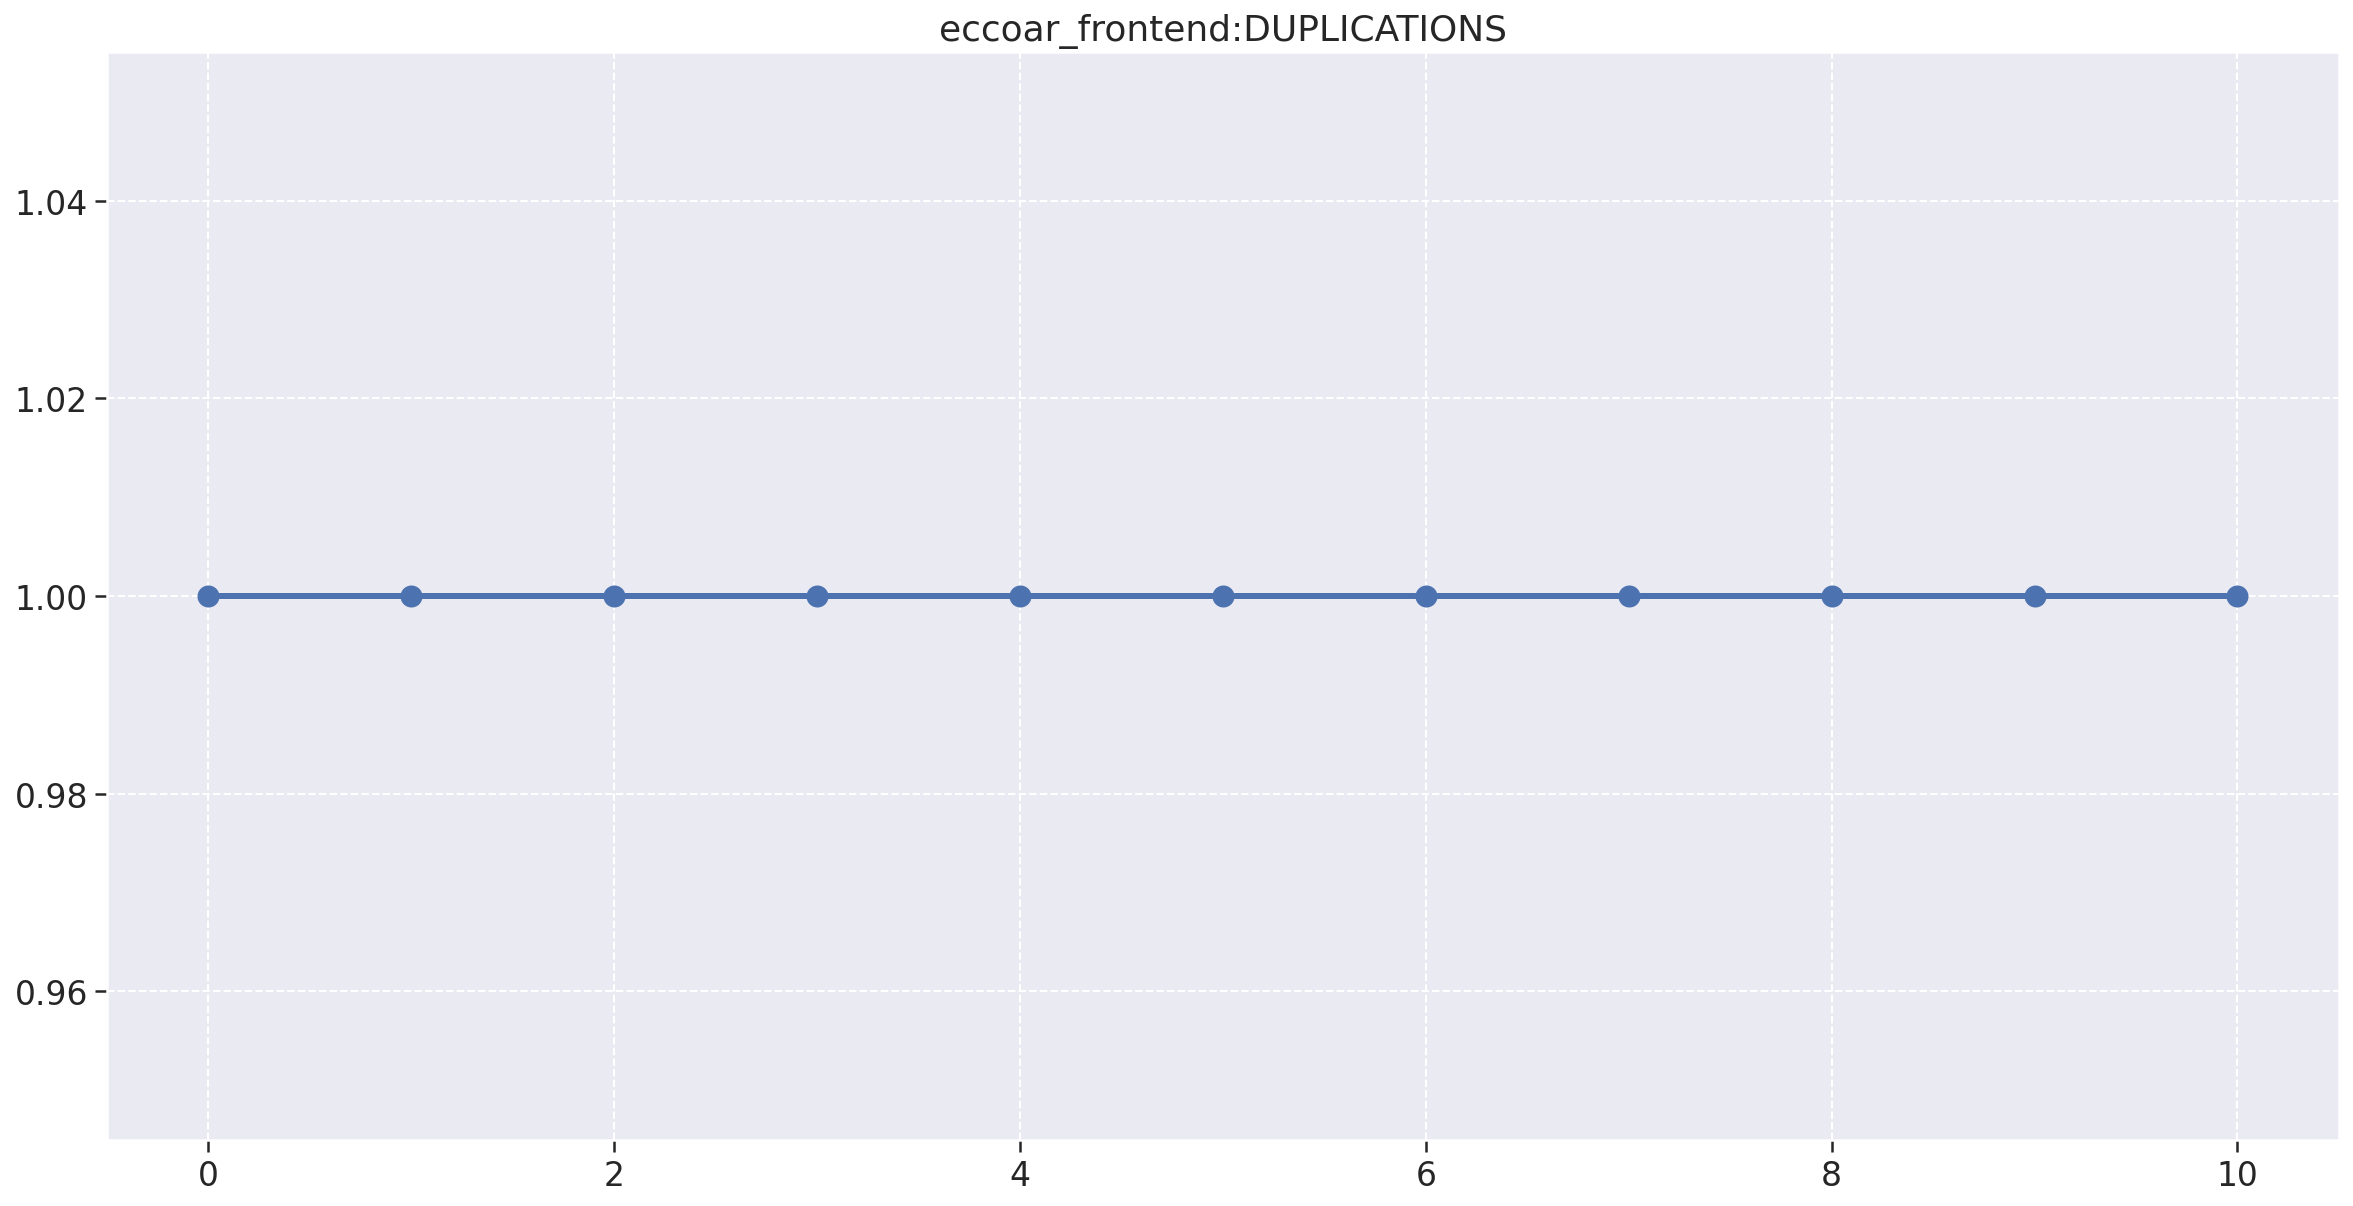

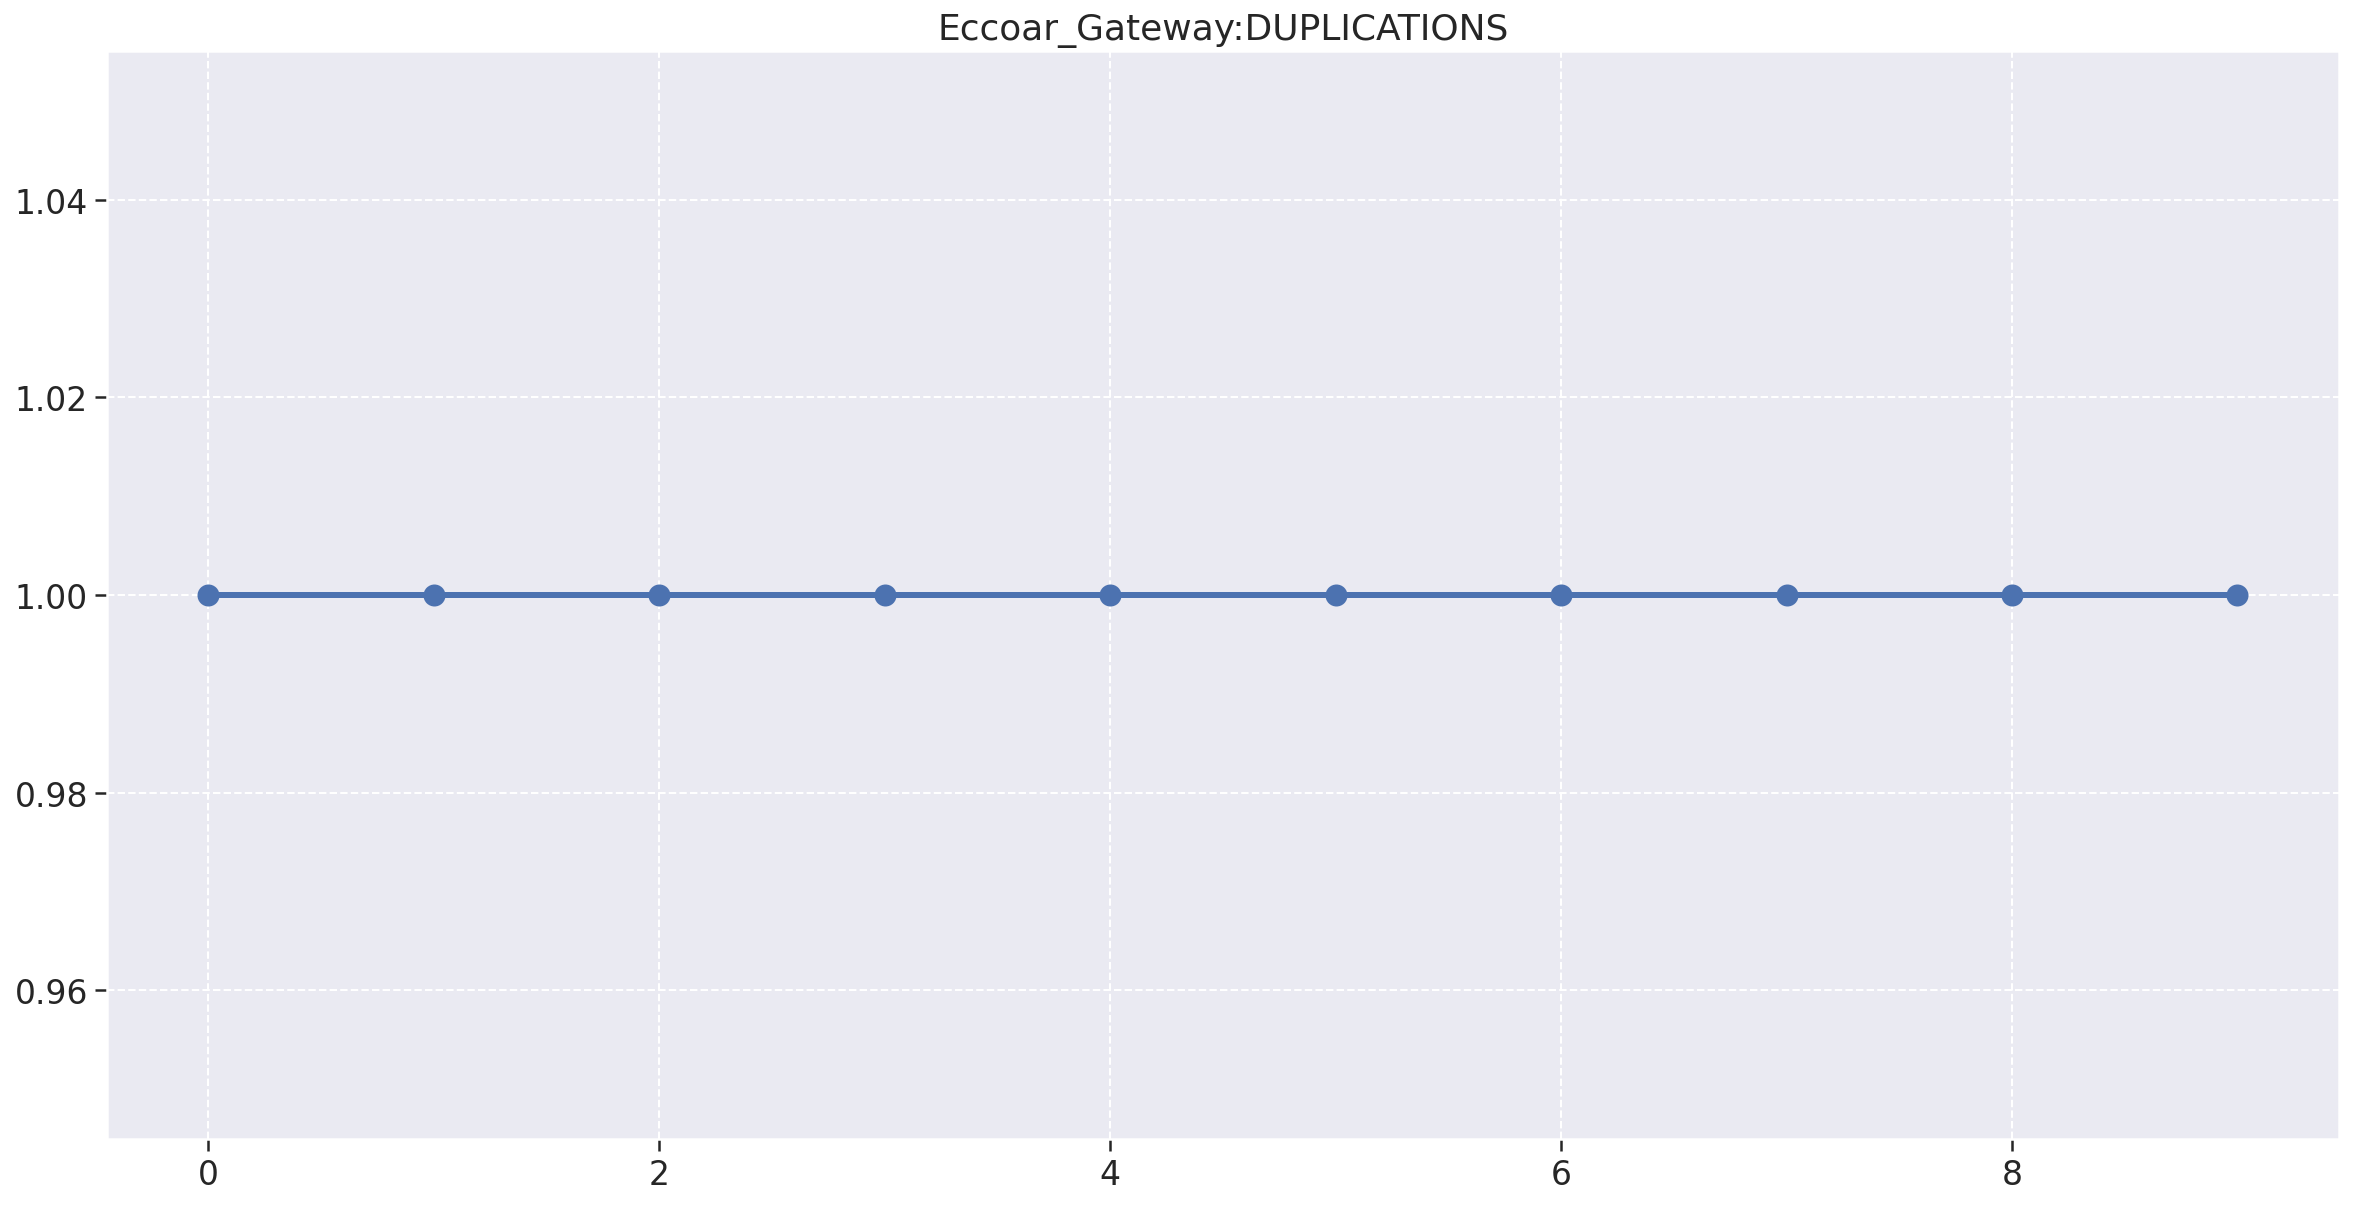

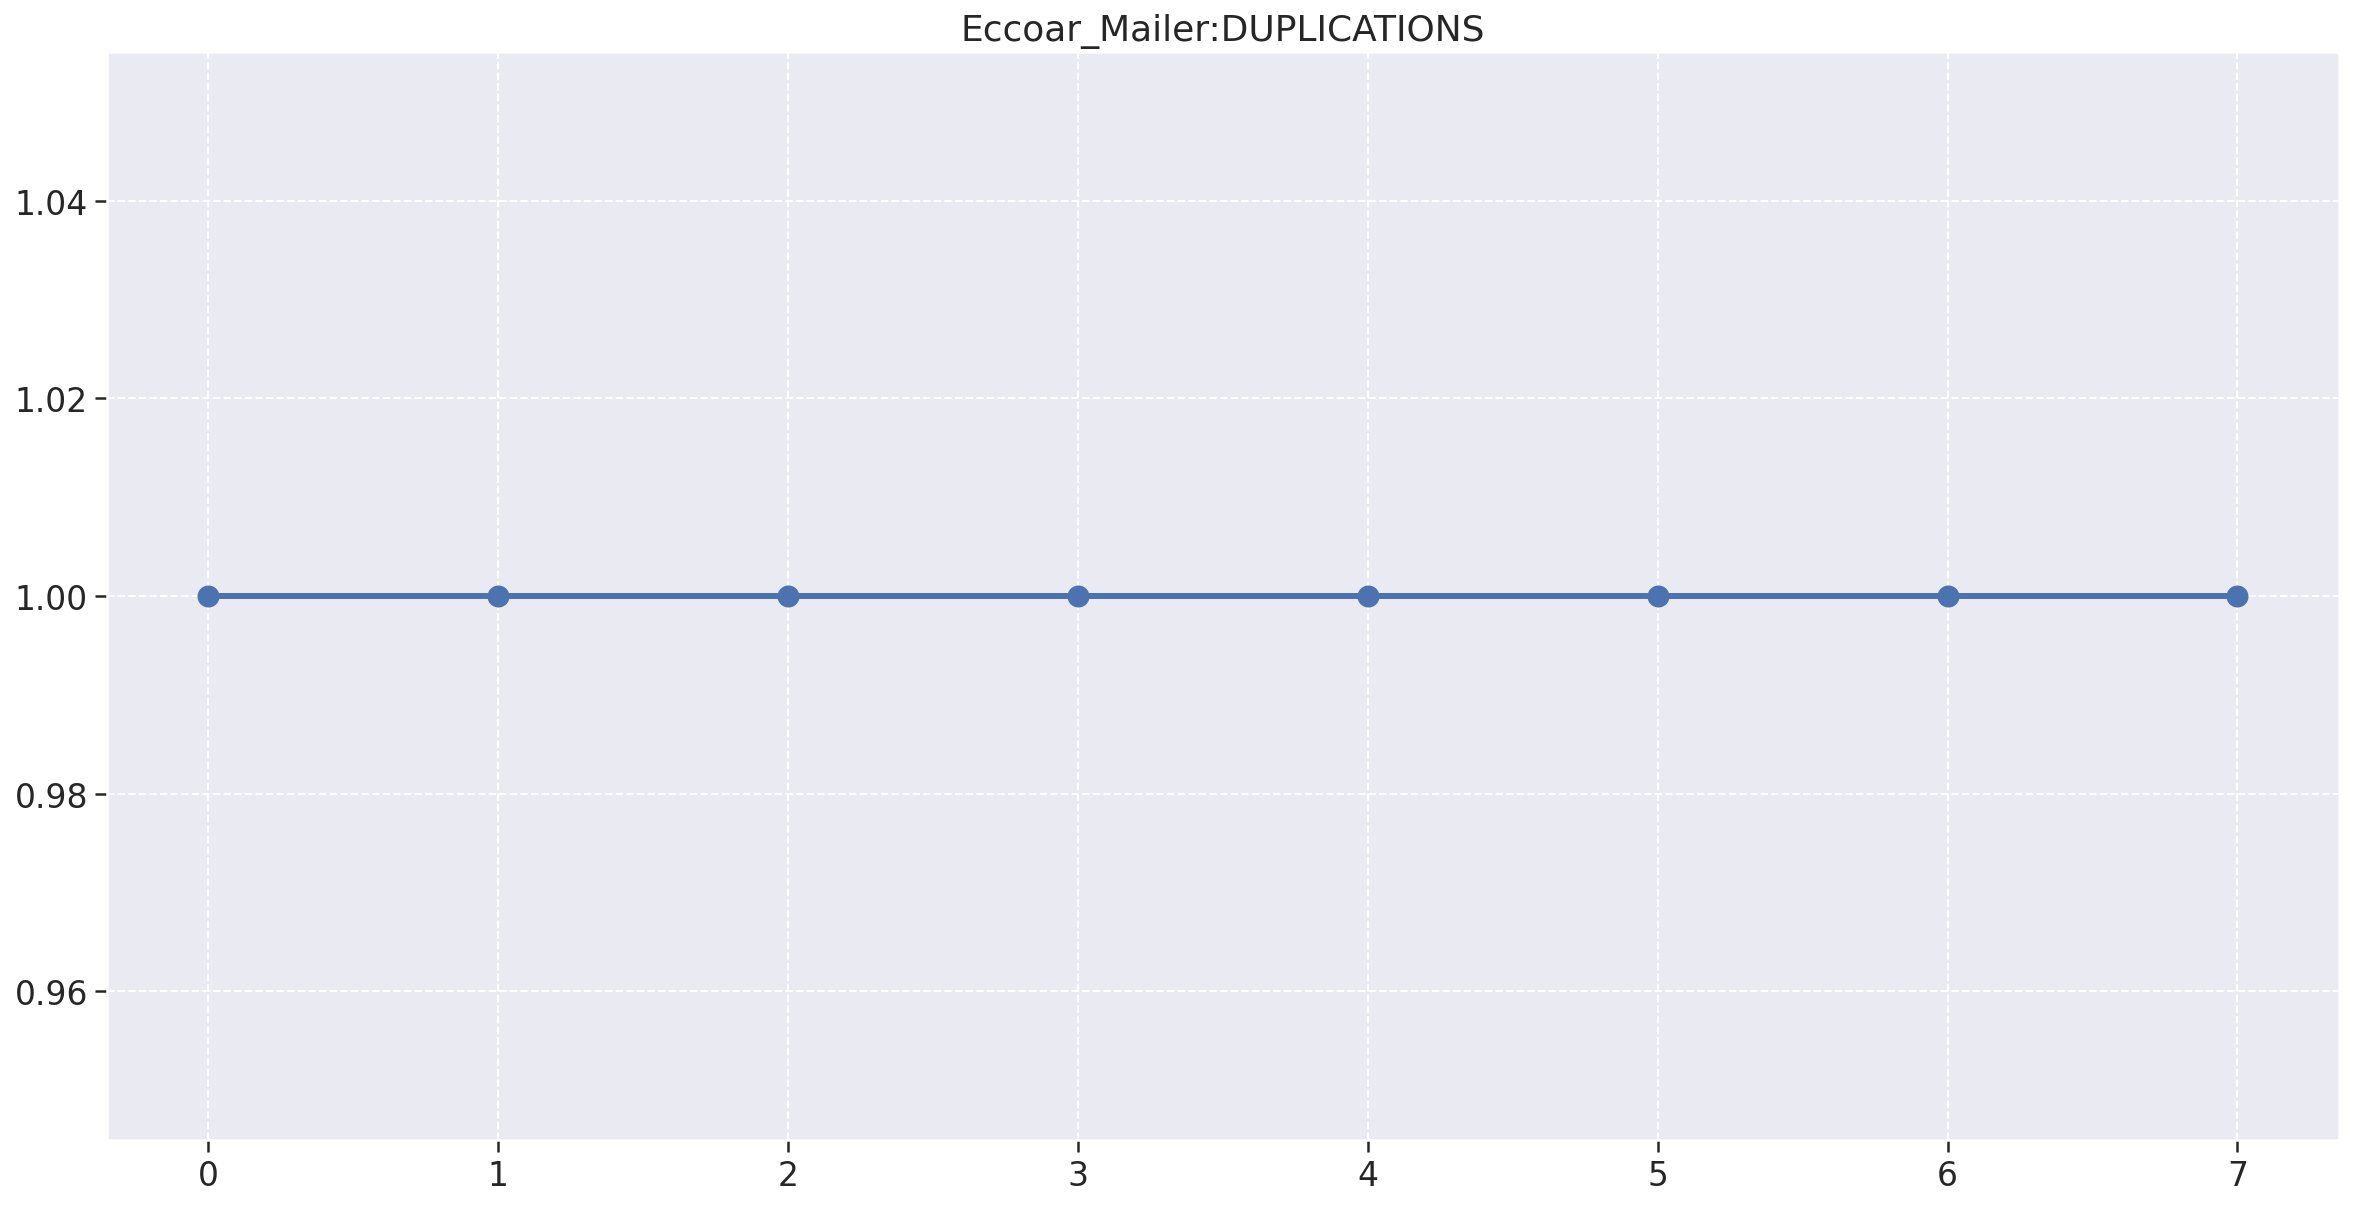

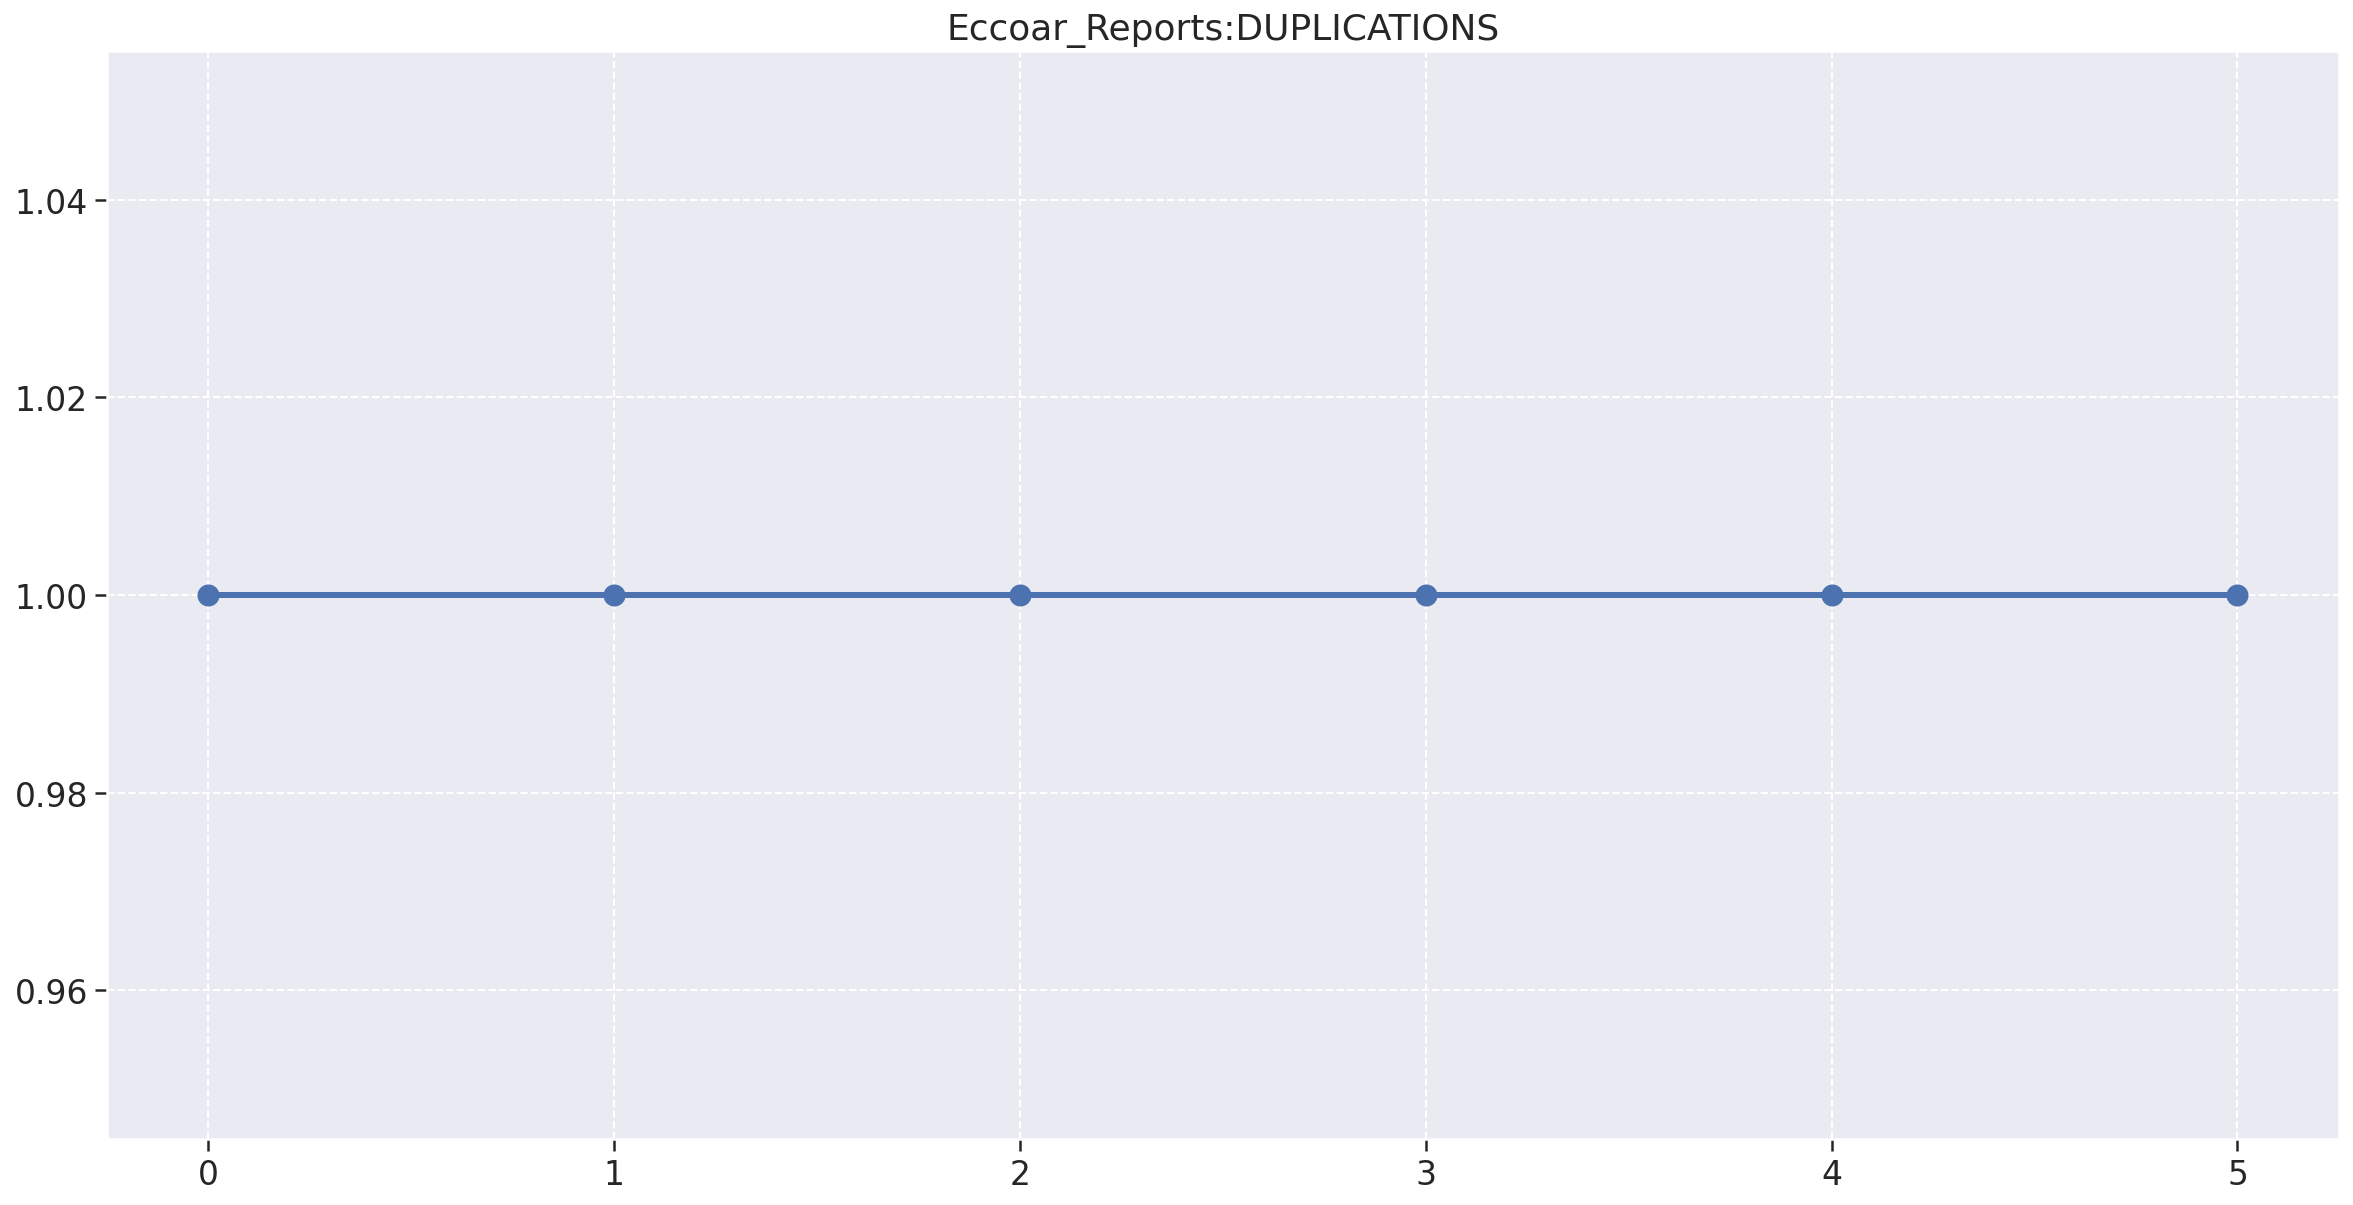

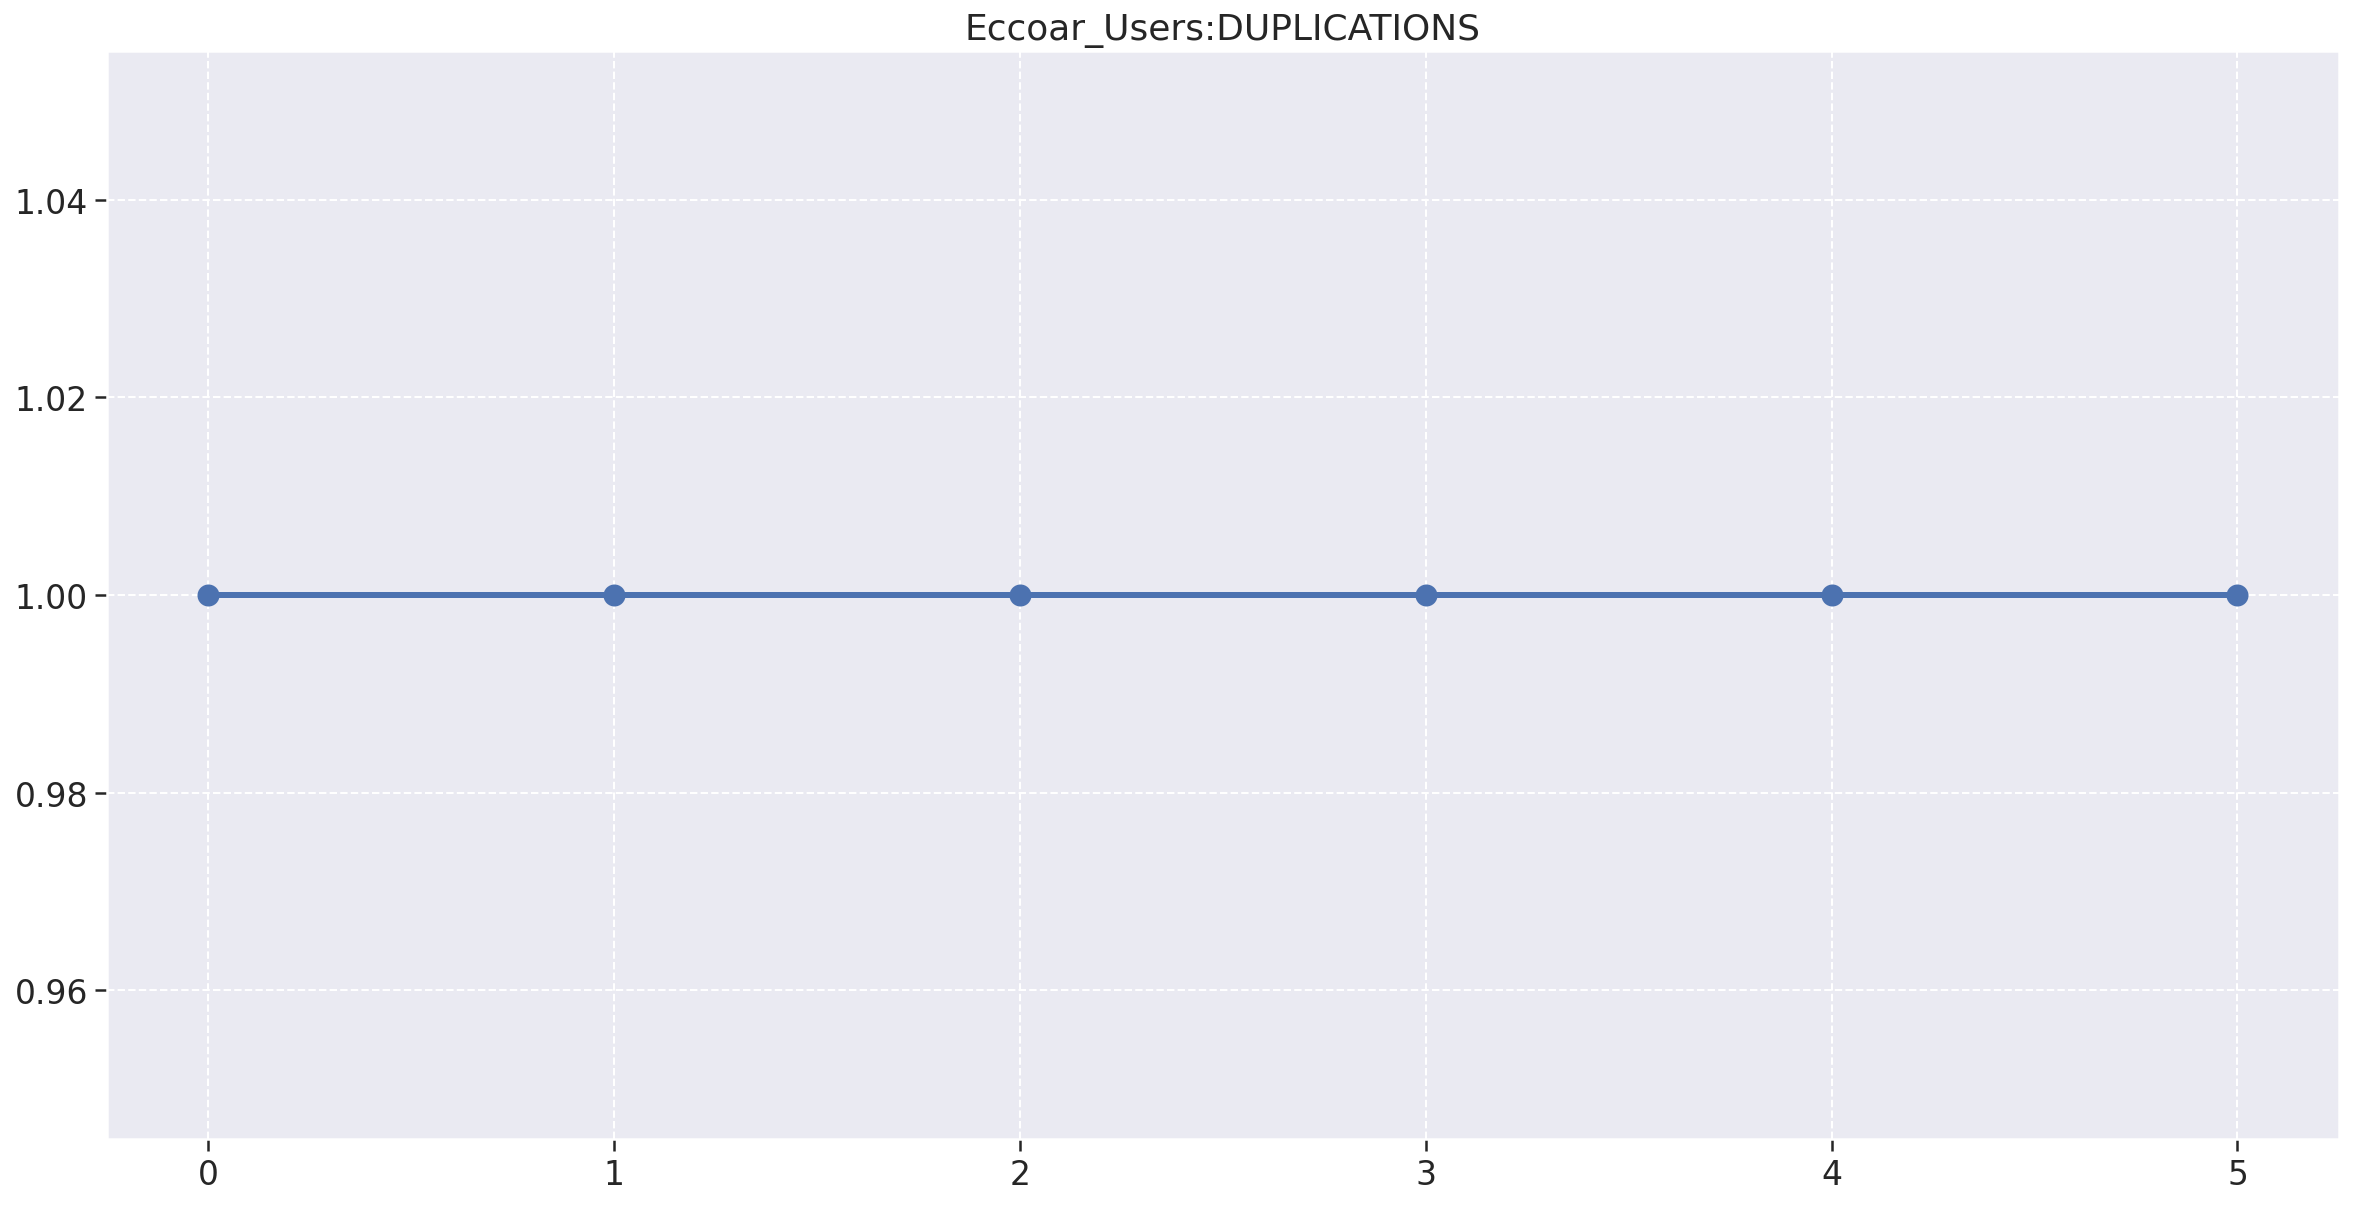

In [44]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [45]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

for repository, metrics_df in repository_metrics.items(): 
    metrics_df['asc1'] = ((metrics_df['m1']*pm1)+(metrics_df['m2']*pm2)+(metrics_df['m3']*pm3))*psc1

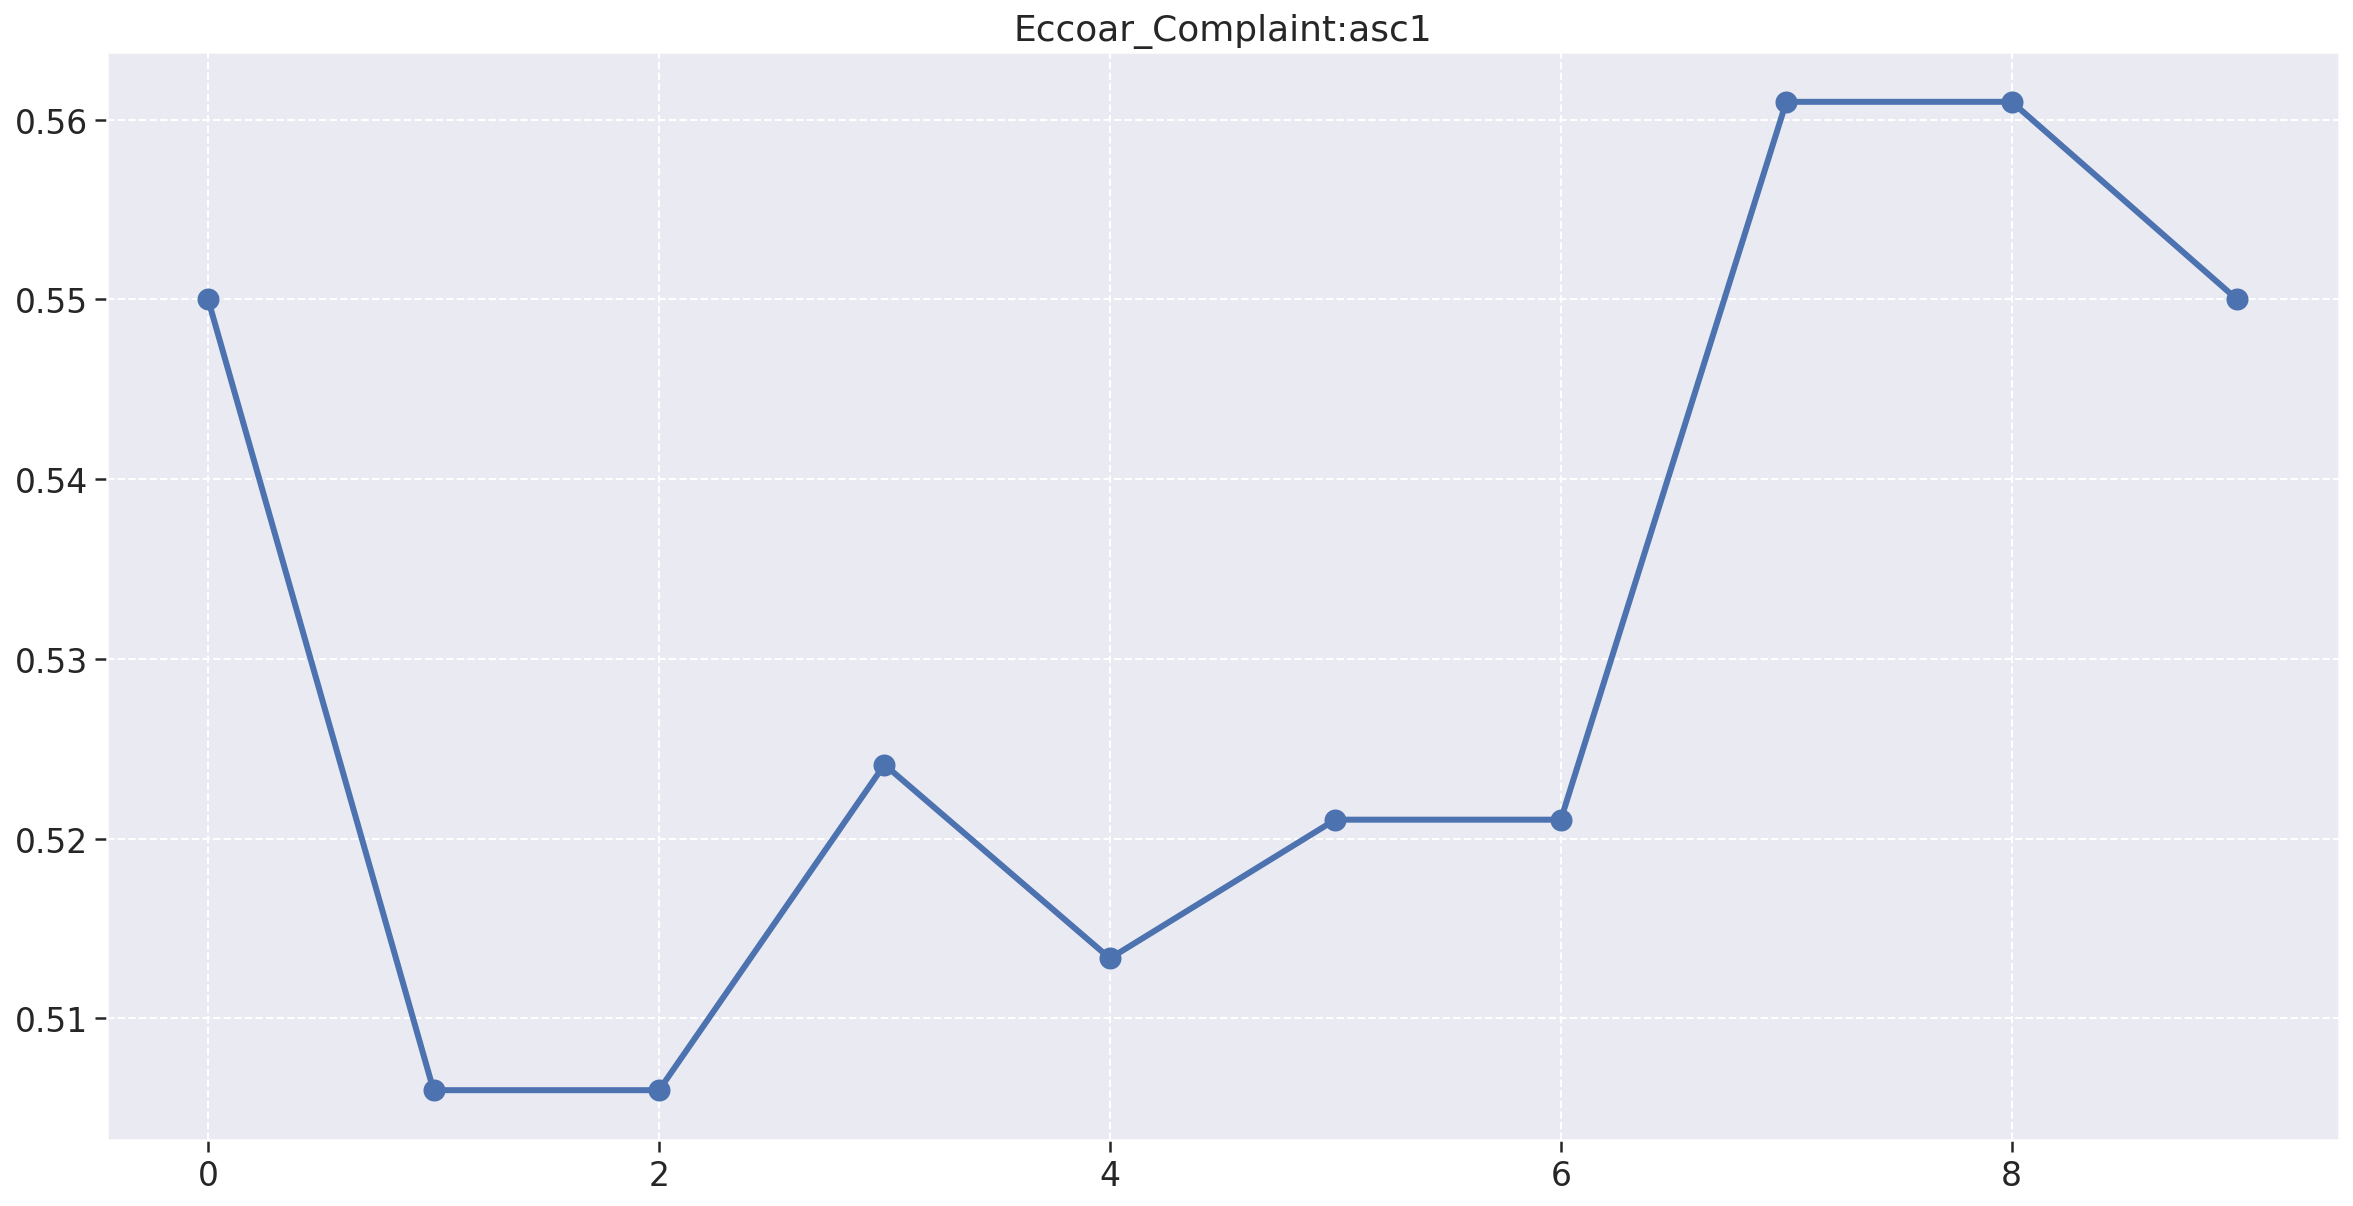

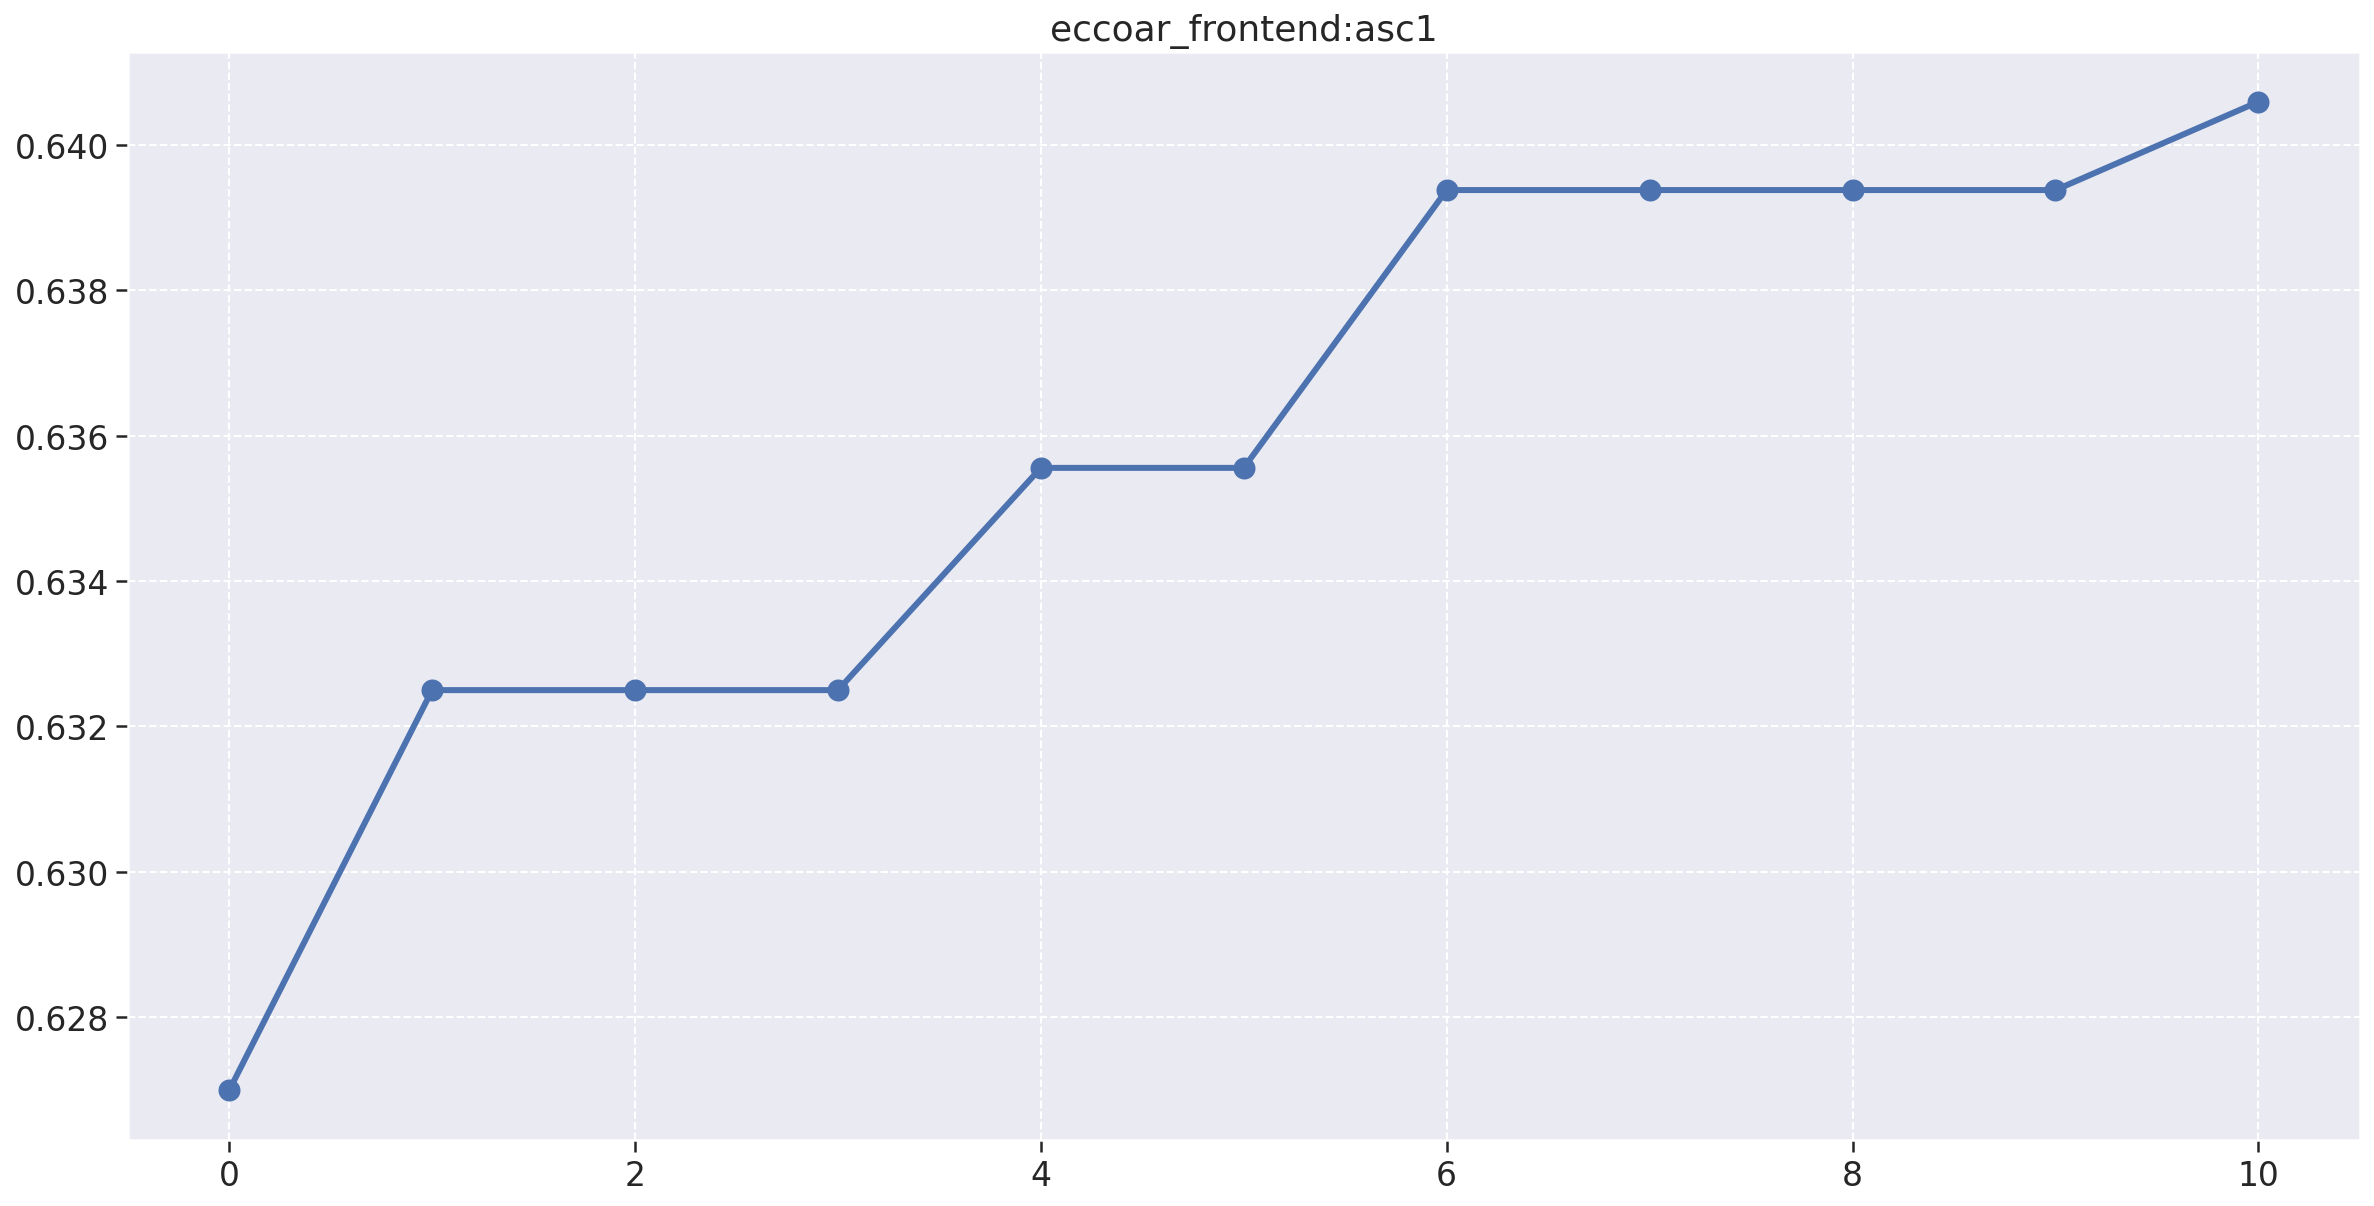

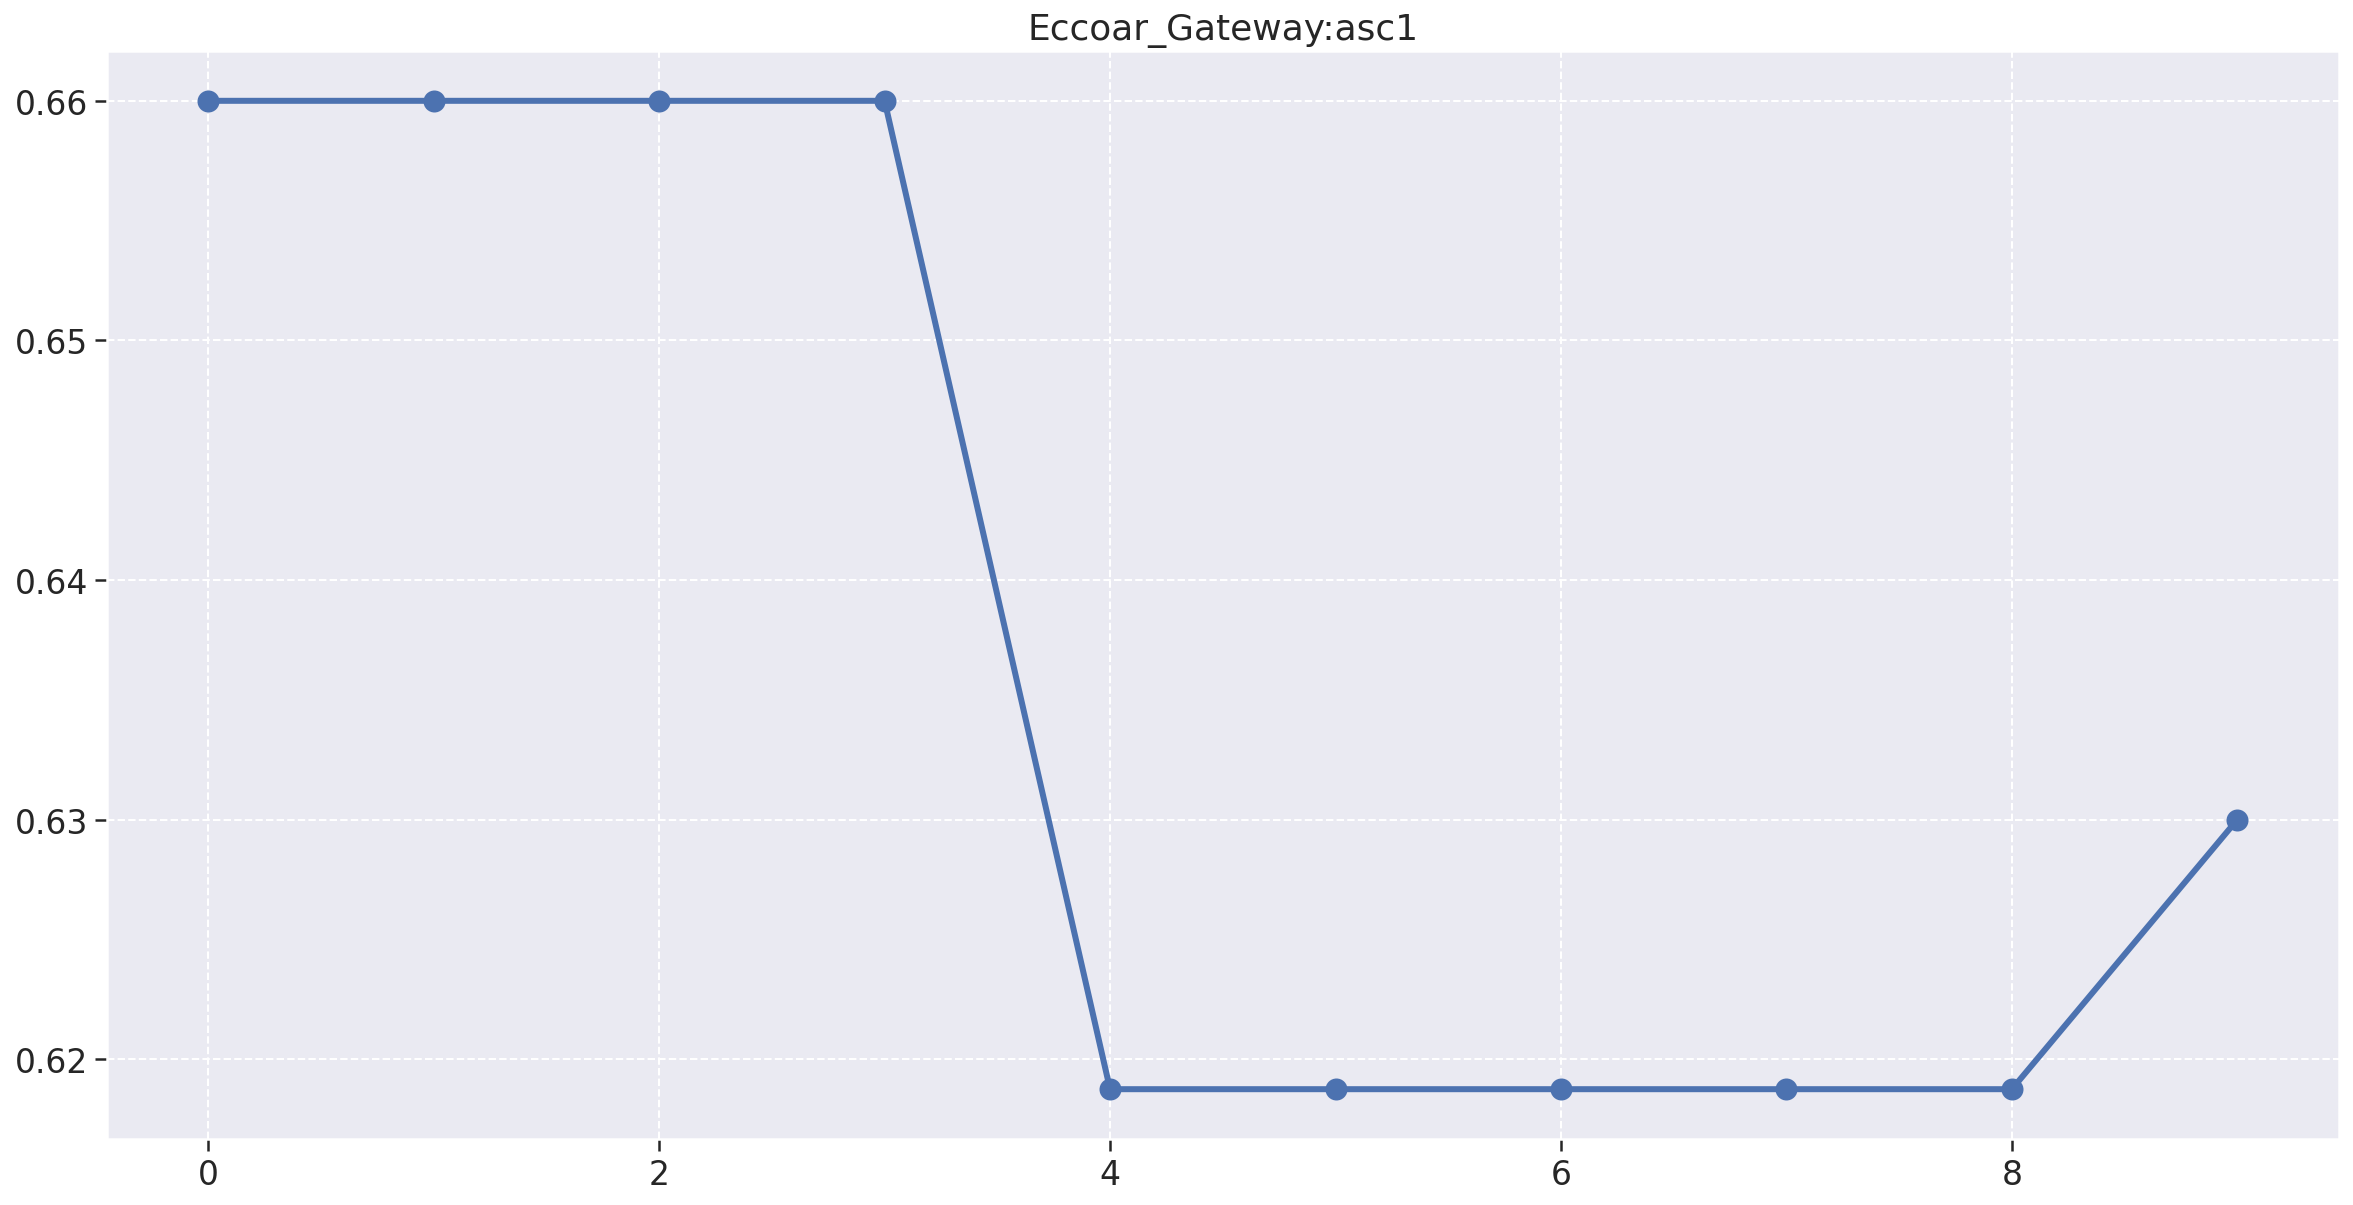

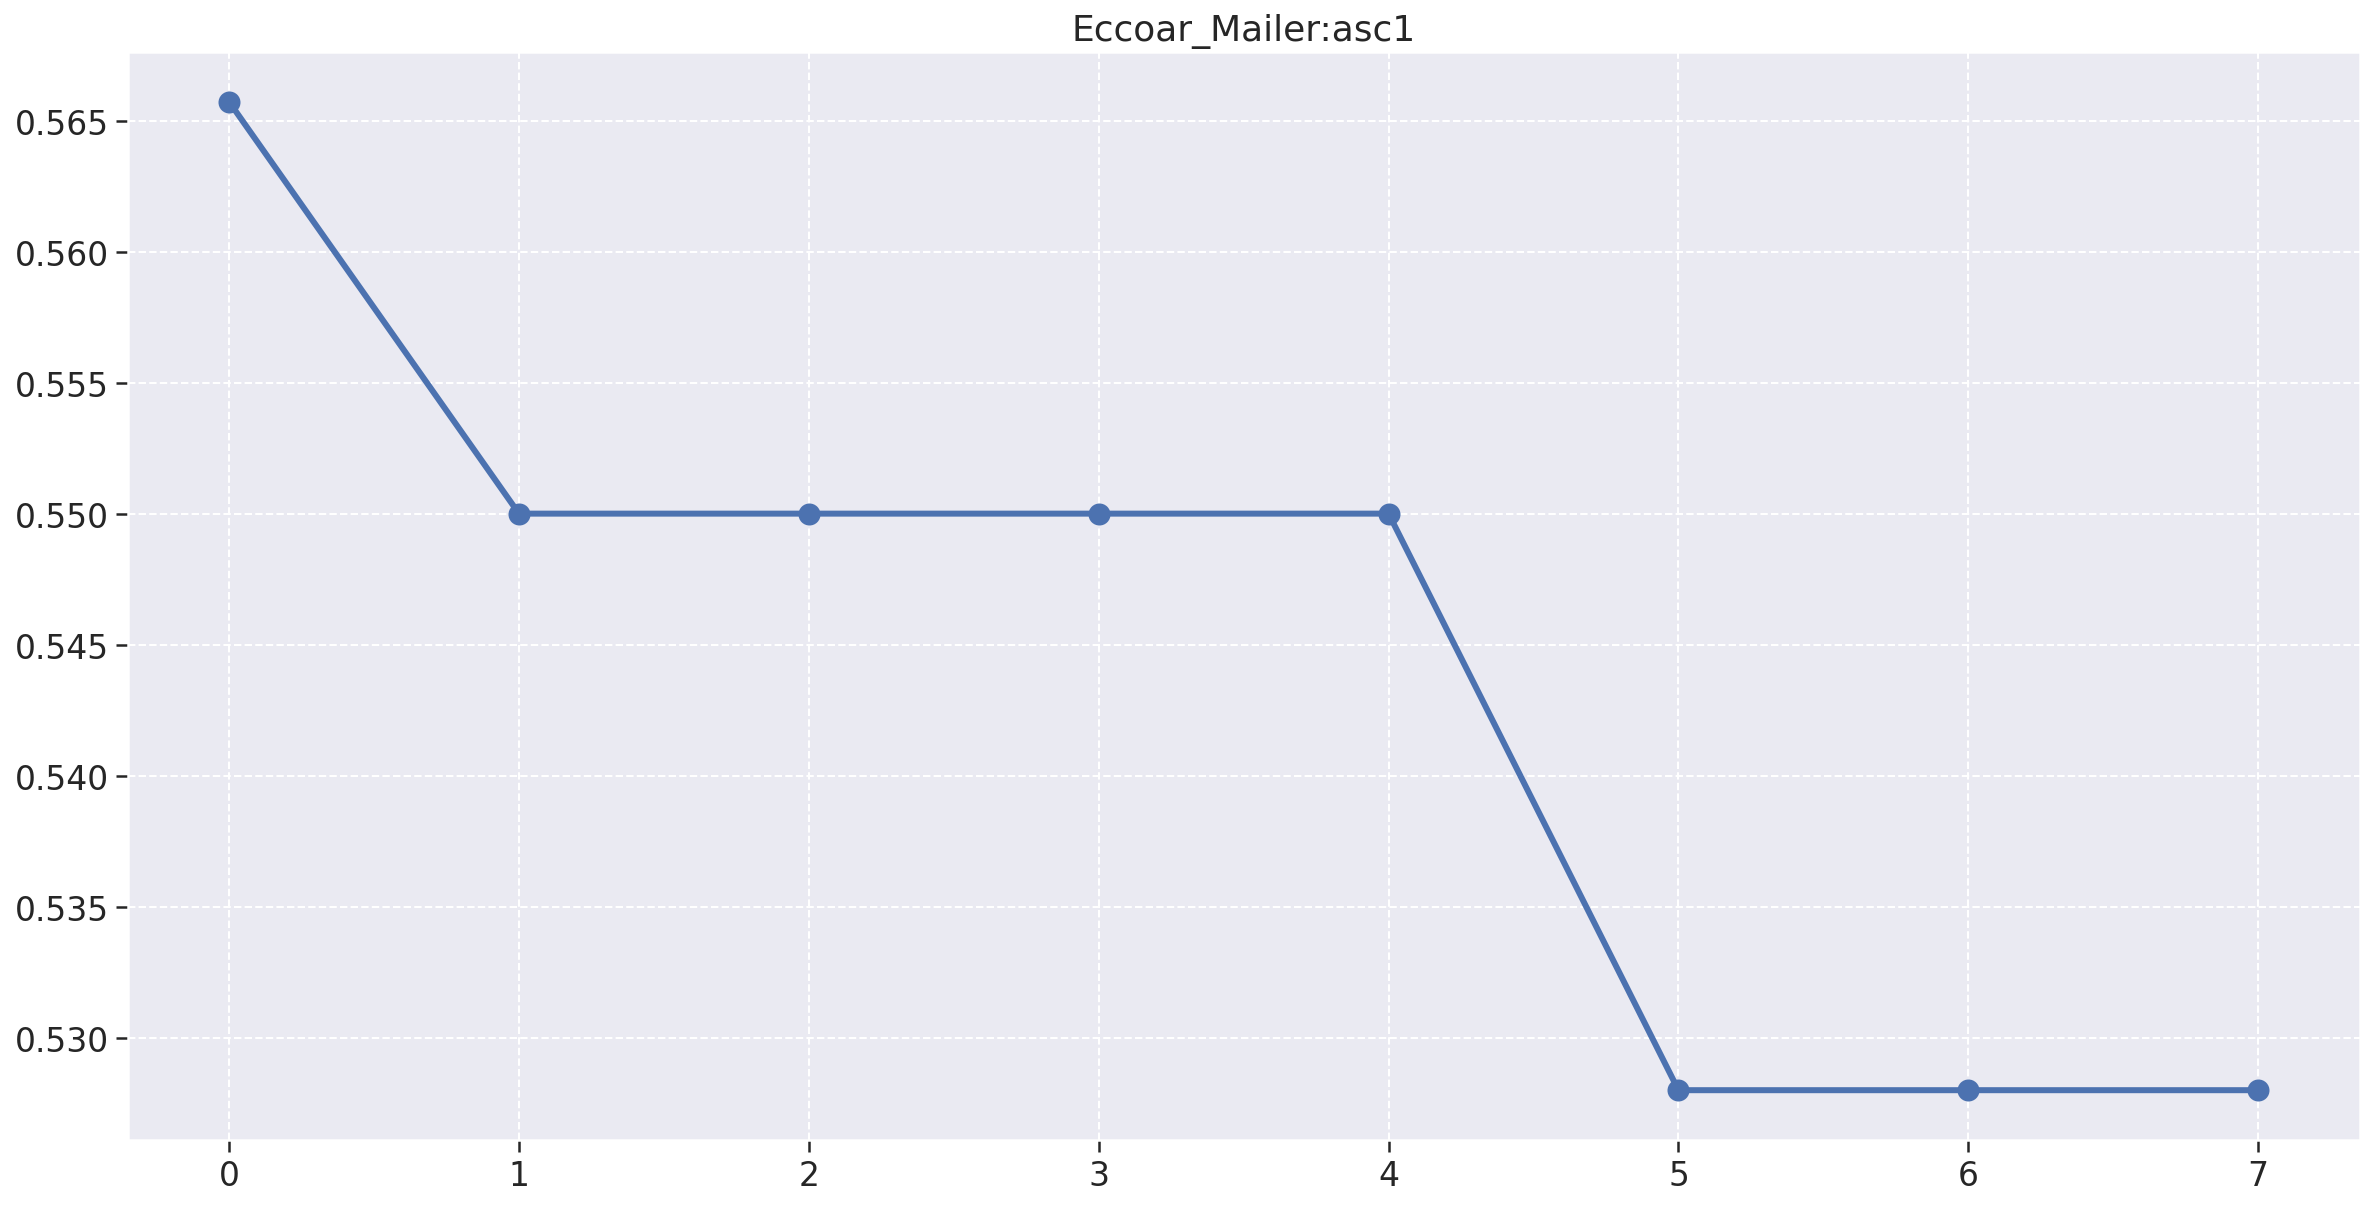

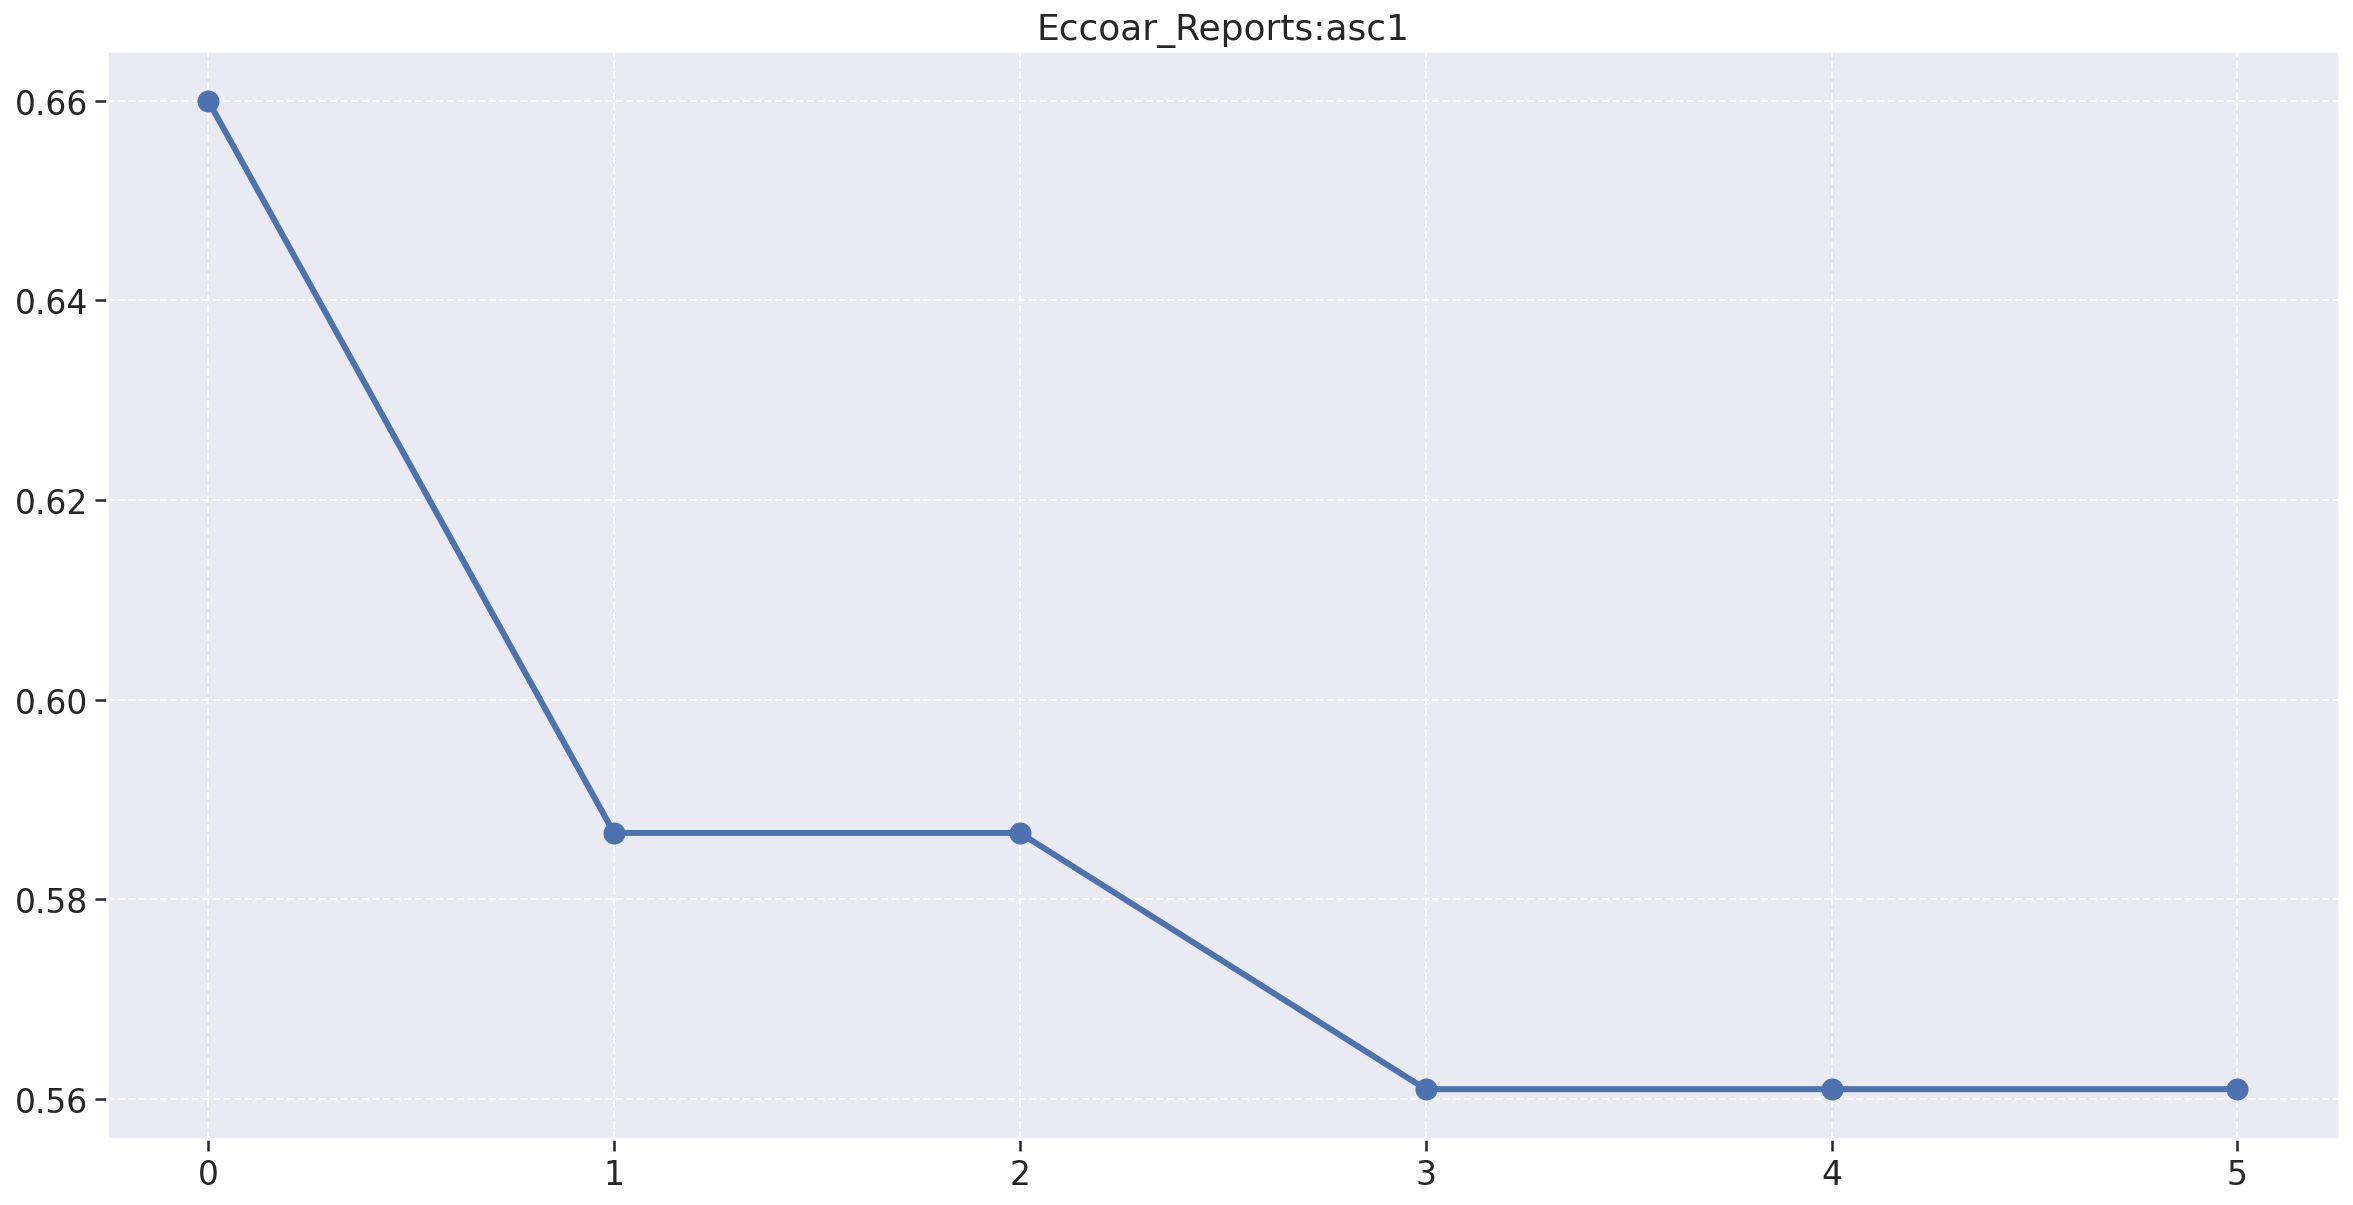

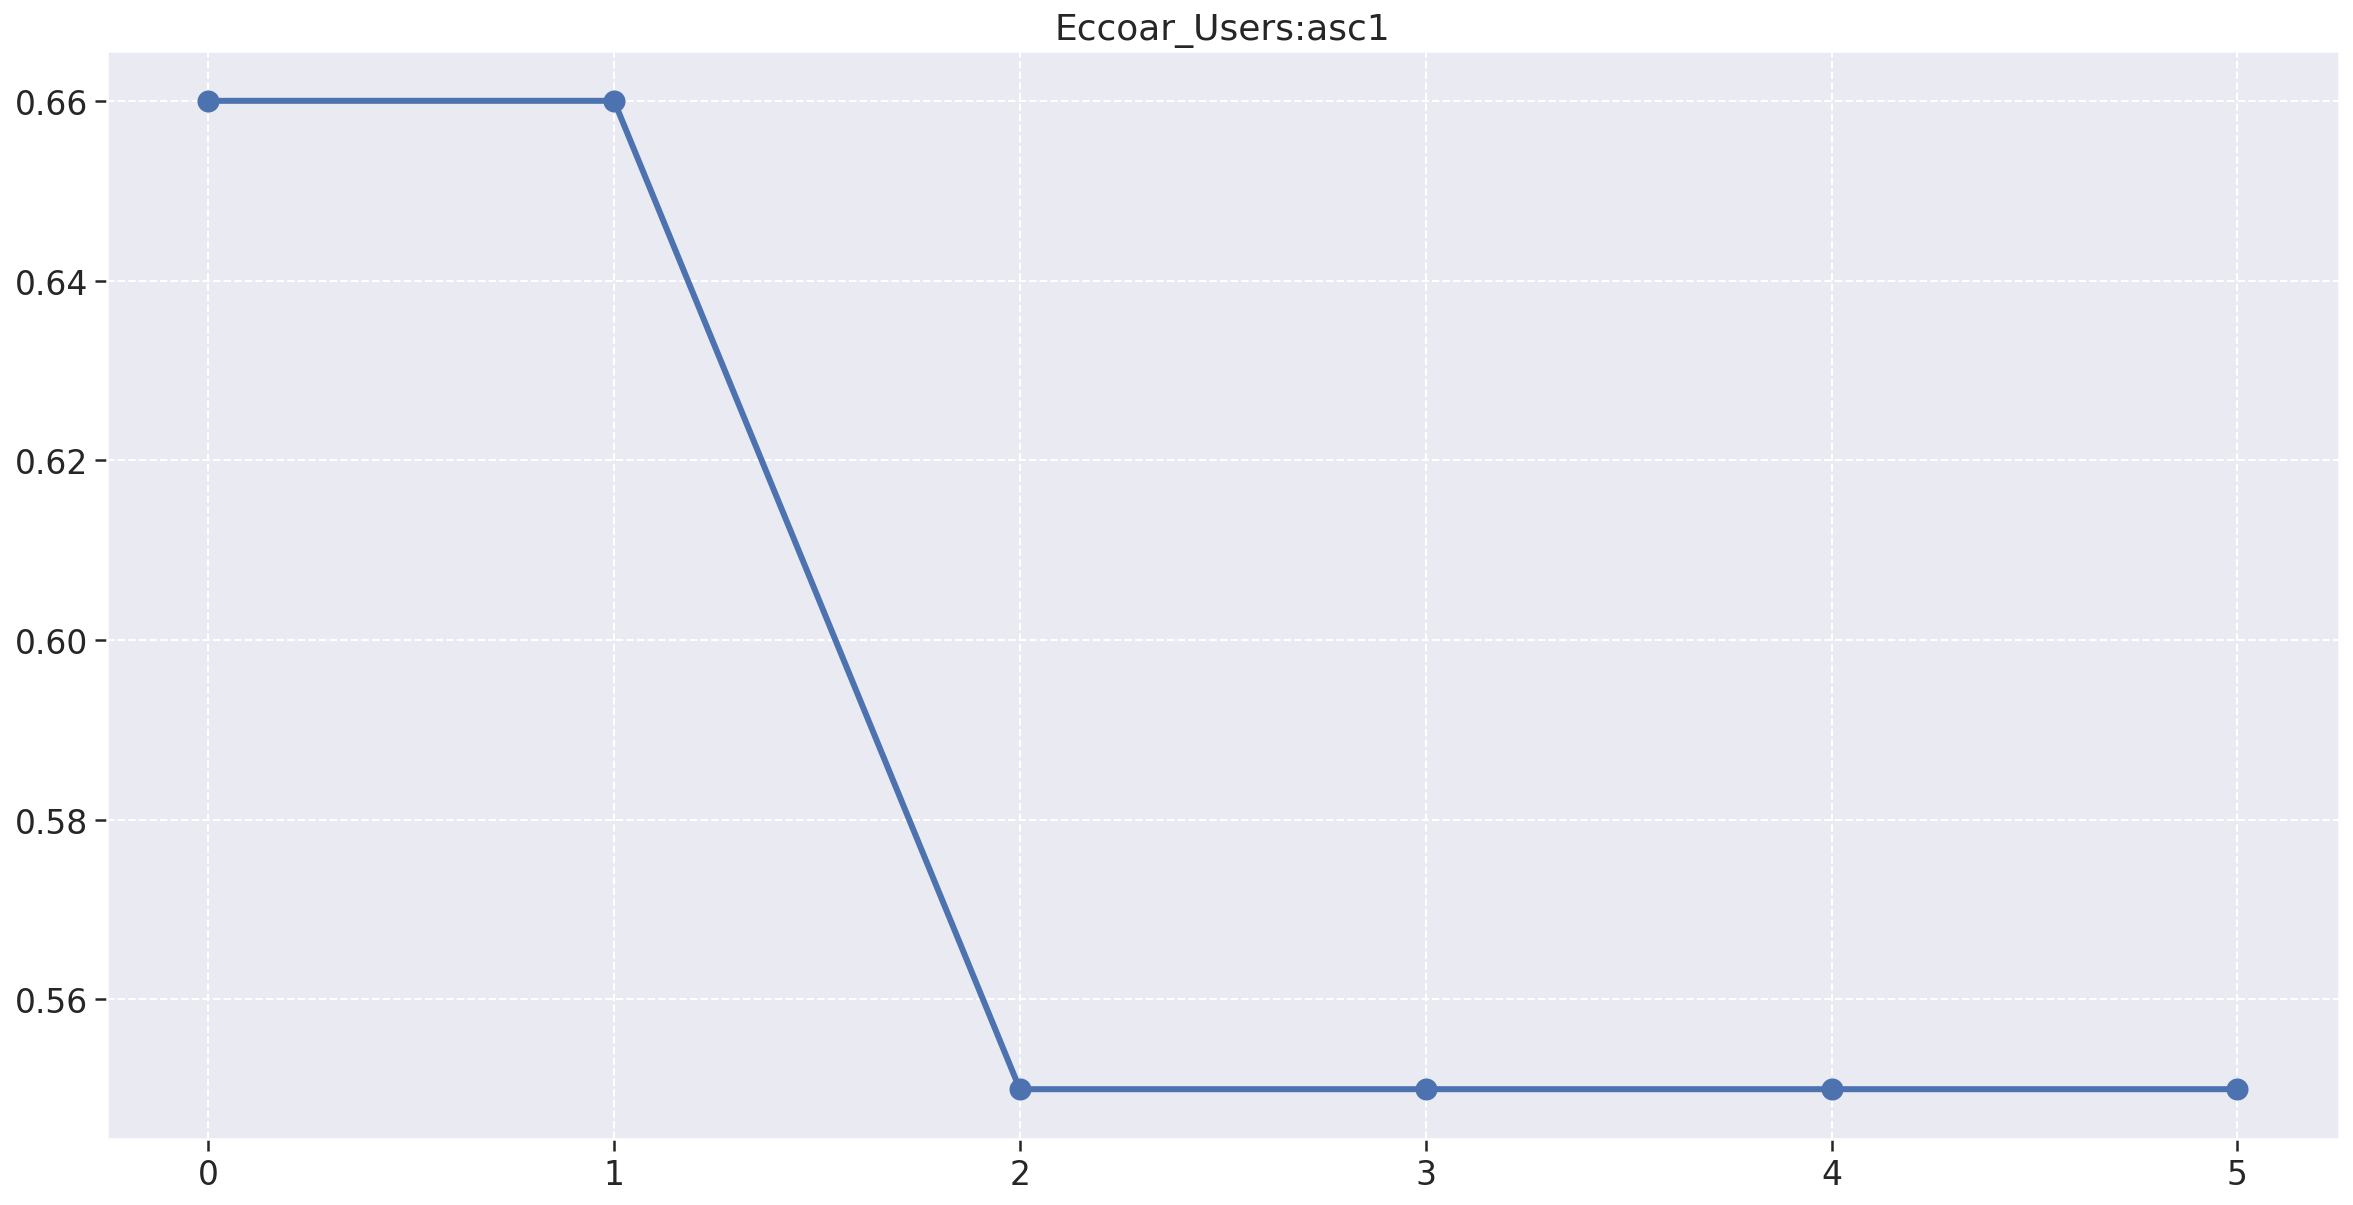

In [46]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:asc1")
    plt.plot(metrics_df['asc1'], linewidth=3, marker='o', markersize=10)

In [47]:
all_metrics_df = pd.DataFrame()

for repository, metrics_df in repository_metrics.items():
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df['ac1'] = all_metrics_df['asc1'] * 1
all_metrics_df['total'] = all_metrics_df['asc1'] * 1

In [48]:
all_metrics_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.666667,0.000000,1.0,Eccoar_Complaint,2021-03-23,0.550000,0.550000,0.550000
1,0.533333,0.000000,1.0,Eccoar_Complaint,2021-04-12,0.506000,0.506000,0.506000
2,0.533333,0.000000,1.0,Eccoar_Complaint,2021-04-17,0.506000,0.506000,0.506000
3,0.588235,0.000000,1.0,Eccoar_Complaint,2021-04-21,0.524118,0.524118,0.524118
4,0.555556,0.000000,1.0,Eccoar_Complaint,2021-04-27,0.513333,0.513333,0.513333
5,0.578947,0.000000,1.0,Eccoar_Complaint,2021-05-01,0.521053,0.521053,0.521053
6,0.578947,0.000000,1.0,Eccoar_Complaint,2021-05-03,0.521053,0.521053,0.521053
7,0.700000,0.000000,1.0,Eccoar_Complaint,2021-05-05,0.561000,0.561000,0.561000
8,0.700000,0.000000,1.0,Eccoar_Complaint,2021-05-10,0.561000,0.561000,0.561000
9,0.666667,0.000000,1.0,Eccoar_Complaint,2021-05-17,0.550000,0.550000,0.550000


In [49]:
metrics_df.to_excel('metrics_df.xlsx', index = False)